In [24]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.max_steps=100
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        self.steps=0

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      self.done = False
      self.steps = 0
      return int(self.start_state_seq)

    def step(self, state, action):
        self.steps+=1
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            p += self.P[state, next_state, action]
            if r <= p:
                break
        if self.steps >= self.max_steps:
          self.done = True
        if(self.wind and np.random.random() < 0.4):
          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          reward = self.R[next_next]
        else:
          reward = self.R[next_state]
        done = True if reward == self.r_goal or reward == self.r_dead else False
        return next_state, reward, done


In [25]:
# specify world parameters
num_cols = 10
num_rows = 10


# Visualizing States

# Defining Softmax and Epsilon Policy

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline
from scipy.special import softmax
import numpy as np
seed = 42
rg = np.random.RandomState(seed)

# Epsilon greedy
def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if not Q[state[0], state[1]].any(): # TODO: eps greedy condition
        return rg.randint(0,4)# TODO: return random action
    else:
      if rg.random()<epsilon :
        return rg.randint(0,4)# TODO: return best action
      else:
        return np.argmax(Q[state[0], state[1]])

def choose_action_softmax(Q, state, tau, rg=rg):
    e = np.exp((Q[state[0], state[1]] - np.max(Q[state[0], state[1]])) / tau)
    e = e / np.sum(e, axis=0)
    # Choose action based on softmax probabilities
    return rg.choice(np.arange(len(e)), p=e)

# Q Plot

# **Task 1:** Implementing **SAARSA** and **Q-Learning** Algorithems

In [27]:
# initialize Q-value
episodes = 5000
print_freq = 100

## **SARSA** *Funtion* with `Epsilon Policy`



In [28]:
def sarsa(env, Q, gamma,alpha, epsilon, plot_heat = False, choose_action = choose_action_epsilon):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon
    # alpha = alpha0

    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        st=env.reset()
        state = seq_to_col_row(st,num_cols)[0]


        done = False
        action = choose_action(Q, state, epsilon)

        k=0
        state_visit_counts[state[0],state[1]]+=1
        while not done:
            state_next, reward, done = env.step(st,action)

            state_next=str(state_next)
            if len(state_next)>1:
              state_next=[int(state_next[0]),int(state_next[1])]
            else:
              state_next=[0,int(state_next)]
            action_next = choose_action(Q,state_next ,epsilon)
            state_visit_counts[state_next[0],state_next[1]]+=1

            # TODO: update equation
            Q[state[0],state[1],action]=Q[state[0],state[1],action]+alpha*(reward+gamma*Q[state_next[0],state_next[1],action_next]-Q[state[0],state[1],action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next
            st=int(str(state[0])+str(state[1]))
            if steps>=100:

              done=True

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                            Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts


In [29]:
# Q, rewards, steps = sarsa(env, Q, gamma = gamma,alpha=alpha0,epsilon=epsilon0, plot_heat=True, choose_action= choose_action_epsilon)

## **Q-Learning** Function with `Epsilon Policy`

In [30]:
def qlearning(env, Q, gamma, alpha,epsilon, plot_heat=False, choose_action=choose_action_epsilon):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)
    epsilon = epsilon
    # alpha = alpha0

    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        st=env.reset()
        state = seq_to_col_row(st,num_cols)[0]


        done = False
        action = choose_action(Q, state, epsilon)

        k=0
        state_visit_counts[state[0],state[1]]+=1
        while not done:
            state_next, reward, done = env.step(st,action)

            state_next=str(state_next)
            if len(state_next)>1:
              state_next=[int(state_next[0]),int(state_next[1])]
            else:
              state_next=[0,int(state_next)]
            action_next = choose_action(Q,state_next ,epsilon)
            state_visit_counts[state_next[0],state_next[1]]+=1

            # TODO: update equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[state_next[0], state_next[1]]) - Q[state[0], state[1], action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next
            st=int(str(state[0])+str(state[1]))
            if steps>=100:

              done=True

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                            Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts


In [31]:
# Q_qlearning, rewards_qlearning, steps_qlearning = qlearning(env, Q, gamma=gamma,alpha=alpha0, epsilon=epsilon0,plot_heat=True, choose_action=choose_action_epsilon)

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reward_curve(rewards_avg, rewards_std):
    episodes = len(rewards_avg)
    plt.figure(figsize=(8, 6))
    plt.plot(rewards_avg, label='Mean Reward', color='blue')
    plt.fill_between(range(episodes), rewards_avg - rewards_std, rewards_avg + rewards_std, color='skyblue', alpha=0.2)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Reward Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_step_curve(steps_avg, steps_std):
    episodes = len(steps_avg)
    plt.figure(figsize=(8, 6))
    plt.plot(steps_avg, label='Mean Steps', color='green')
    plt.fill_between(range(episodes), steps_avg - steps_std, steps_avg + steps_std, color='lightgreen', alpha=0.2)
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title('Step Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
import numpy as np
import matplotlib.pyplot as plt






In [33]:
def plot_Q(Q, message = "Q plot"):

    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def plot_counts(Q, message="counts plot"):

    plt.title(message)
    plt.pcolor(Q, edgecolors='k', linewidths=2)
    plt.colorbar()
    plt.show()


In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot(epsilon, alpha, gamma, env, wind, p_good_transition, learning_function):
    num_expts = 5
    reward_avgs = []
    steps_avgs = []
    state_visit_avgs=[]
    Q_values_list = []
    env.wind = wind
    print(env.start_state)

    if wind:
        env.add_transition_probability(p_good_transition=1.0, bias=0.5)
    else:
        env.add_transition_probability(p_good_transition=p_good_transition, bias=0.5)

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))
        Q = np.zeros((env.num_rows, env.num_cols, 4))
        rg = np.random.RandomState(i)
        if learning_function == 'sarsa':
            Q_result, rewards, steps,state_visit = sarsa(env, Q.copy(), gamma=gamma, alpha=alpha, epsilon=epsilon, plot_heat=False,
                                              choose_action=choose_action_epsilon)
        elif learning_function == 'qlearning':
            Q_result, rewards, steps,state_visit = qlearning(env, Q.copy(), gamma=gamma, alpha=alpha, epsilon=epsilon,
                                                  plot_heat=False, choose_action=choose_action_epsilon)
        reward_avgs.append(rewards)
        steps_avgs.append(steps)
        state_visit_avgs.append(state_visit)
        Q_values_list.append(Q_result)
    Q_values_mean = np.mean(Q_values_list, axis=0)

    reward_avgs = np.mean(reward_avgs, axis=0)
    reward_stds = np.std(reward_avgs, axis=0)
    steps_avgs = np.mean(steps_avgs, axis=0)
    steps_stds = np.std(steps_avgs, axis=0)
    state_visit_avgs = np.mean(state_visit_avgs, axis=0)

    plot_reward_curve(reward_avgs, reward_stds)
    plot_step_curve(steps_avgs, steps_stds)



    plot_Q(Q_values_mean,message= "Qmax: %.2f, Qmin: %.2f"%( Q_values_mean.max(), Q_values_mean.min()))
    plot_counts(state_visit_avgs, message="counts plot")
    return reward_avgs, reward_stds, steps_avgs, steps_stds, Q_values_mean, state_visit_avgs

epsilon =  0.08 alpha =  0.12 gamma =  0.97 wind =  False p =  1.0 learning =  sarsa start =  [0, 4]
[[0 4]]
Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-24-4f035c3d5aef>:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)
<ipython-input-28-8a41346a8ff5>:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state[0],state[1],action]=Q[state[0],state[1],action]+alpha*(reward+gamma*Q[state_next[0],state_next[1],action_next]-Q[state[0],state[1],action])
<ipython-input-28-8a41346a8ff5>:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e

Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1205.89it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1185.16it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:04<00:00, 1071.56it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:04<00:00, 1240.46it/s]


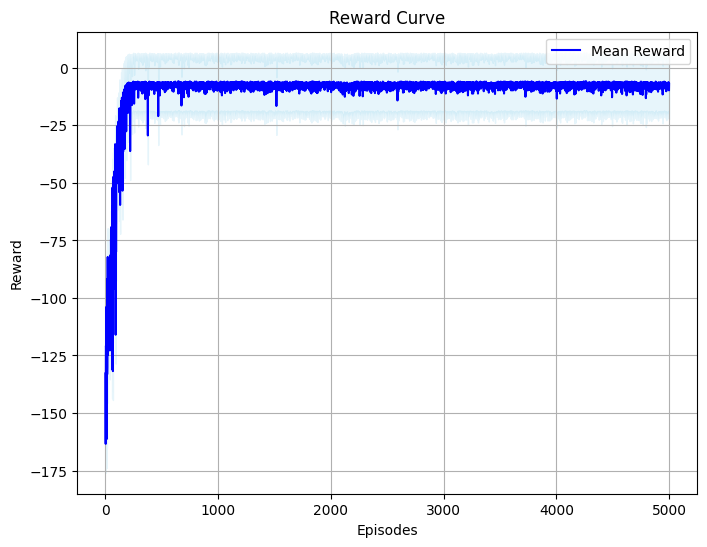

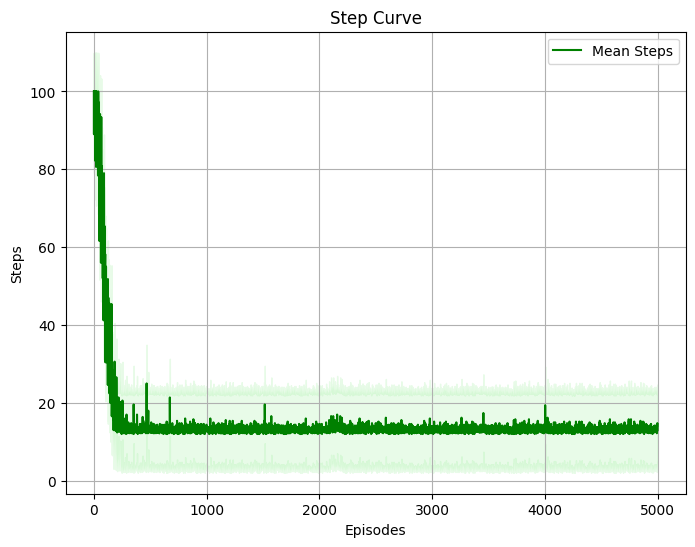

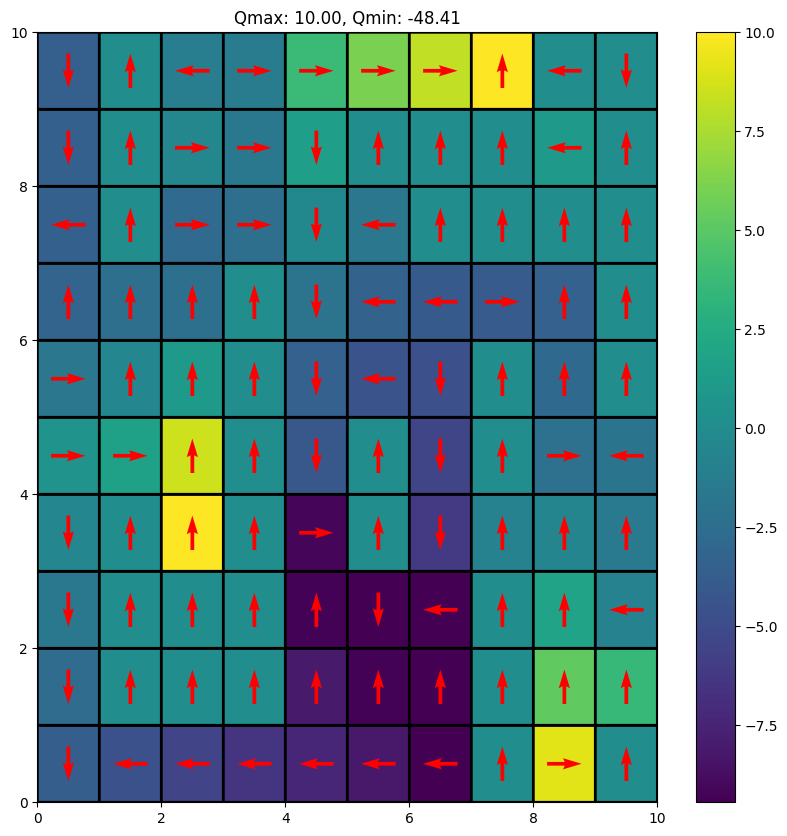

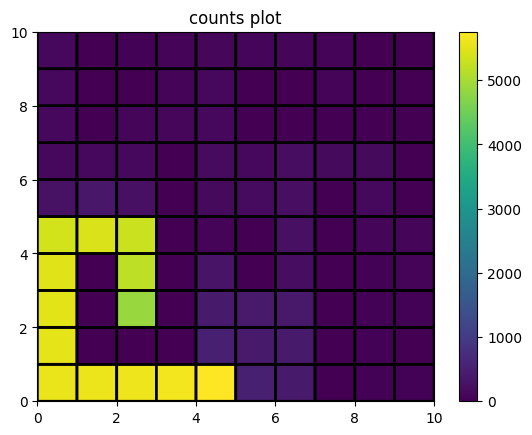

epsilon =  0.08 alpha =  0.12 gamma =  0.95 wind =  False p =  0.7 learning =  sarsa start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 666.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 755.80it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 706.84it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:06<00:00, 749.00it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:07<00:00, 678.42it/s]


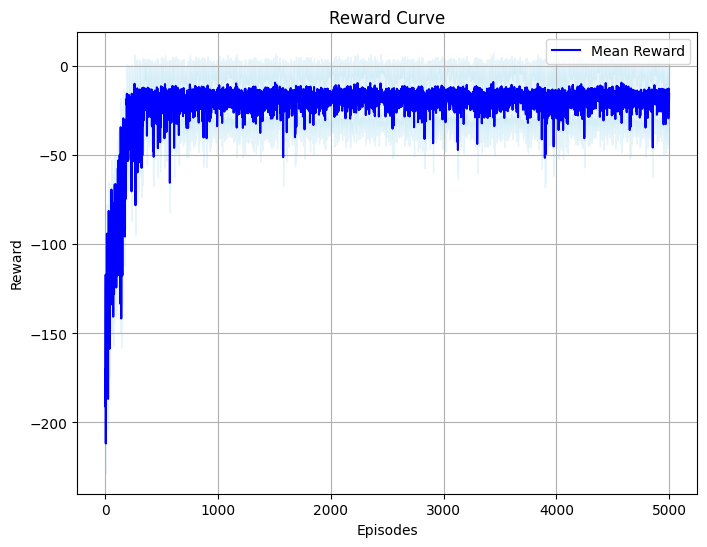

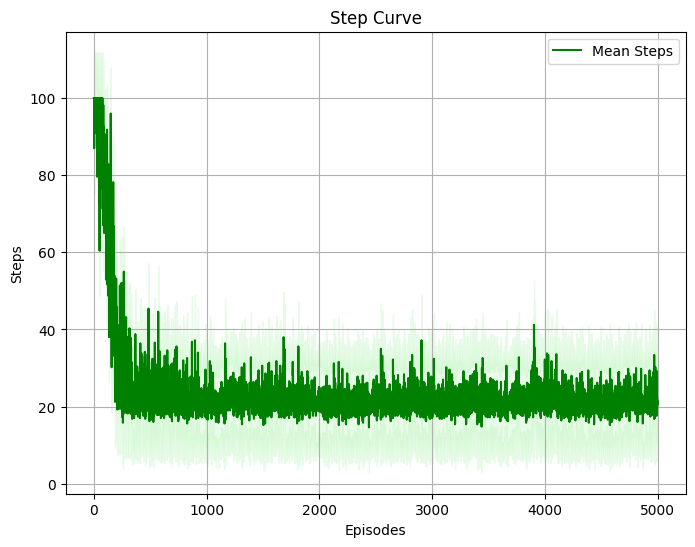

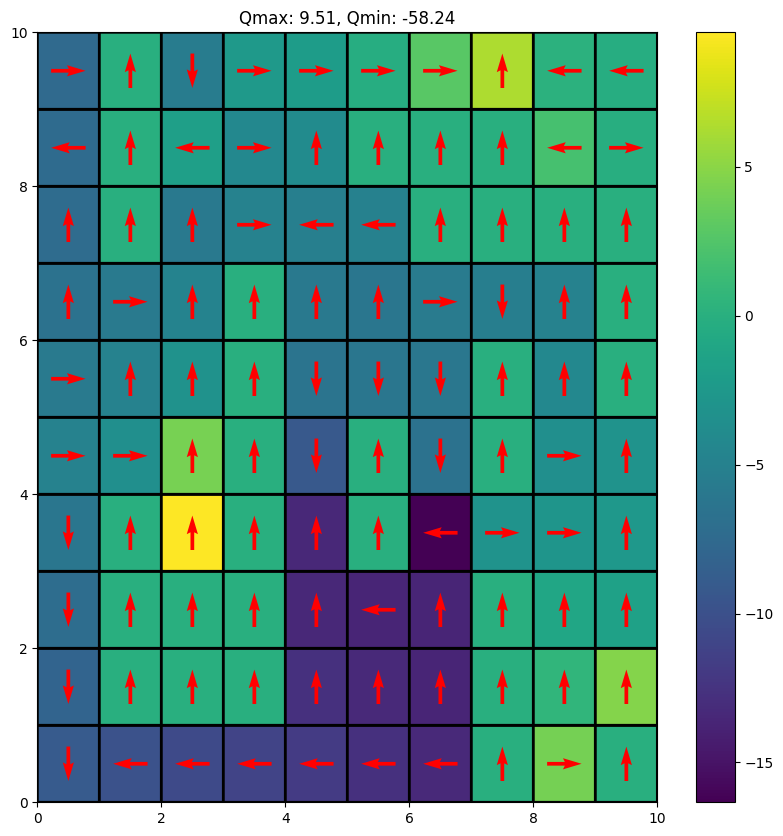

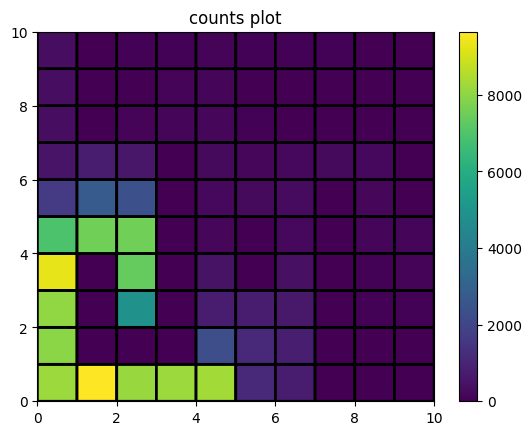

epsilon =  0.08 alpha =  0.12 gamma =  0.97 wind =  True p =  1.0 learning =  sarsa start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 803.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 913.83it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 953.05it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:05<00:00, 936.03it/s] 


Experiment: 5


100%|██████████| 5000/5000 [00:05<00:00, 891.78it/s]


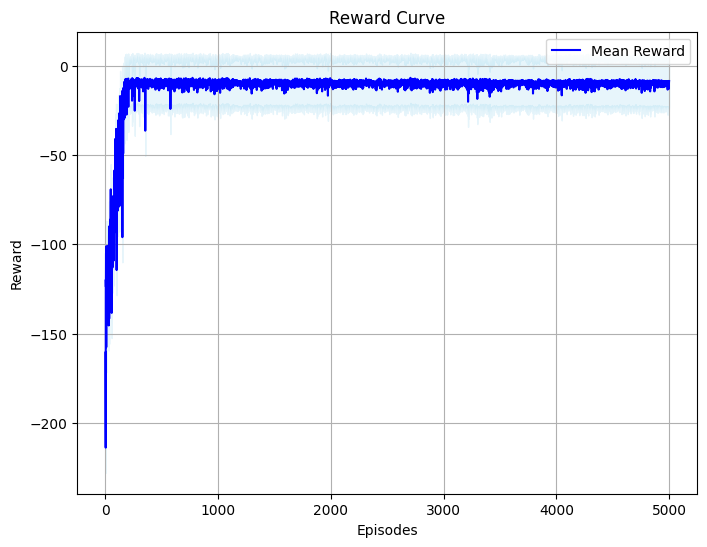

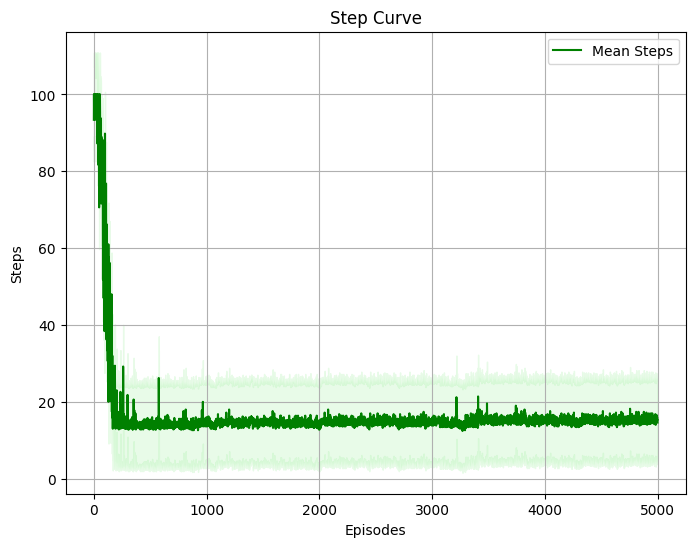

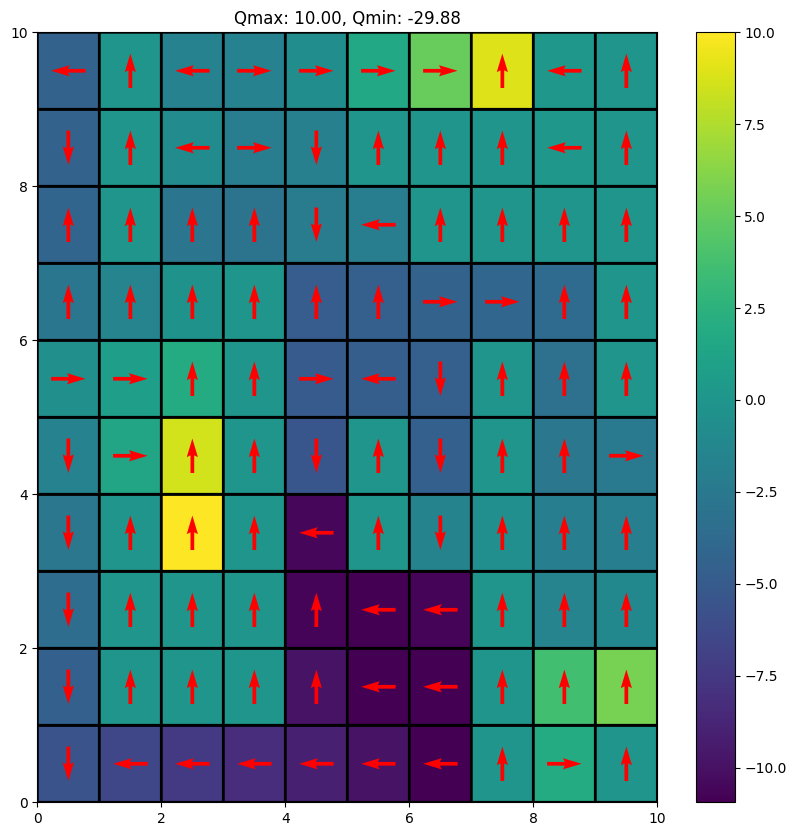

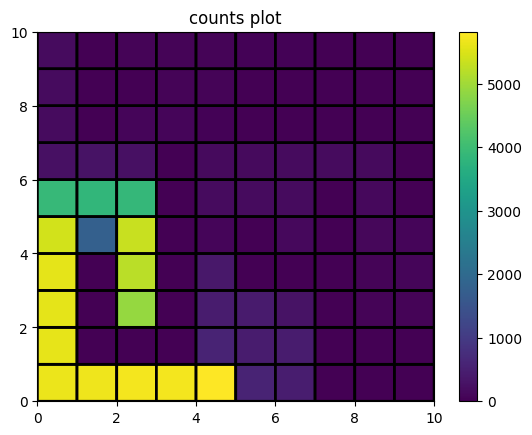

epsilon =  0.08 alpha =  0.12 gamma =  0.97 wind =  False p =  1.0 learning =  qlearning start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 925.72it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1069.56it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 988.96it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:05<00:00, 945.38it/s] 


Experiment: 5


100%|██████████| 5000/5000 [00:04<00:00, 1111.49it/s]


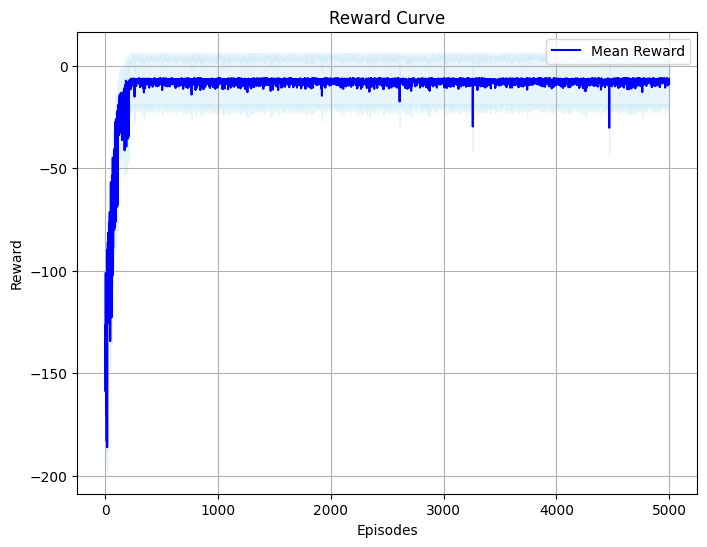

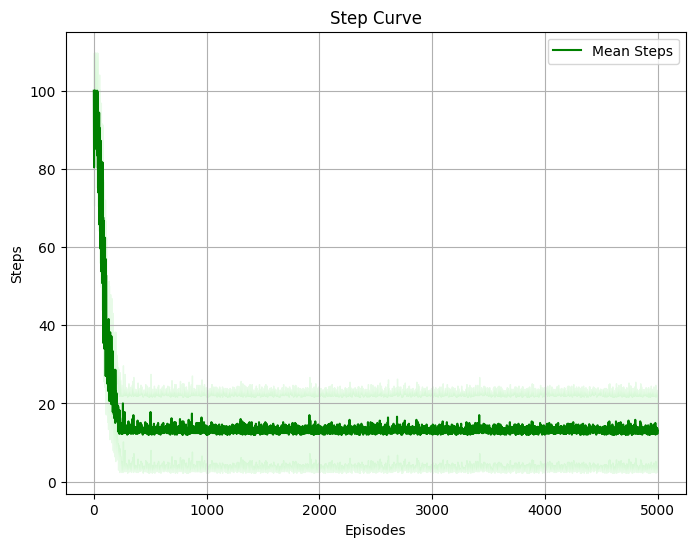

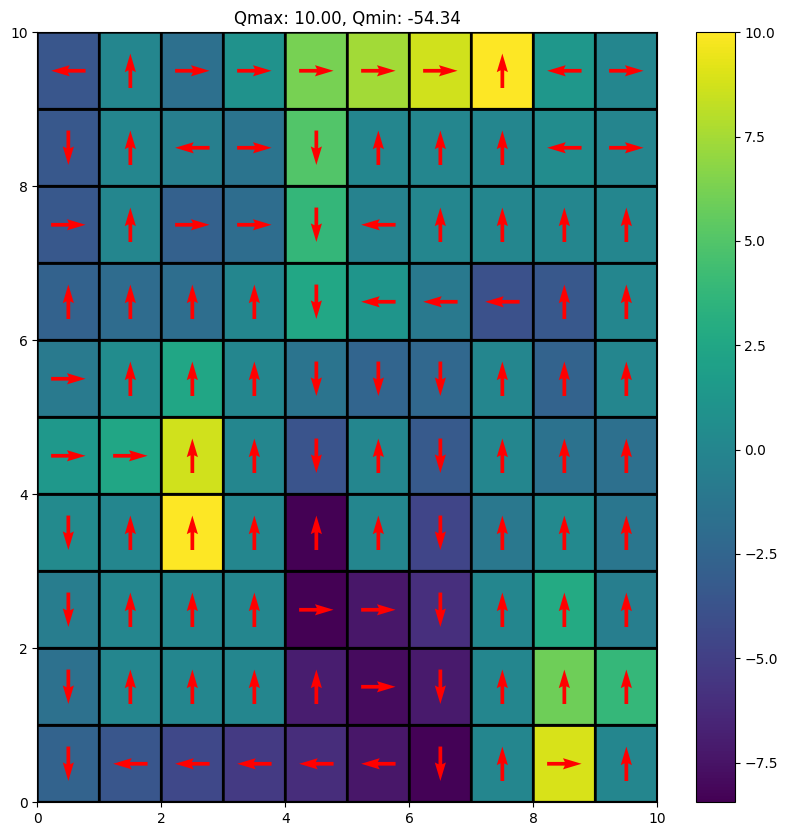

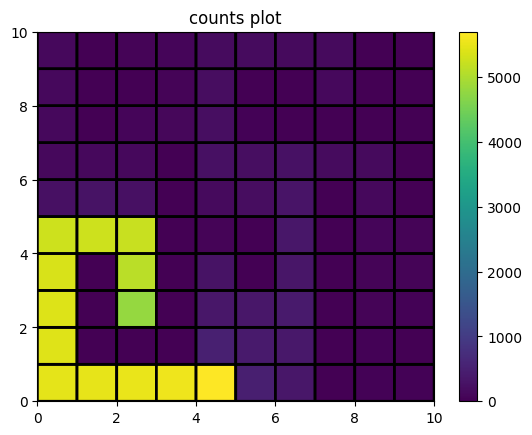

epsilon =  0.08 alpha =  0.12 gamma =  0.95 wind =  False p =  0.7 learning =  qlearning start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 614.82it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 613.20it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 643.79it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:08<00:00, 575.00it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:08<00:00, 623.79it/s]


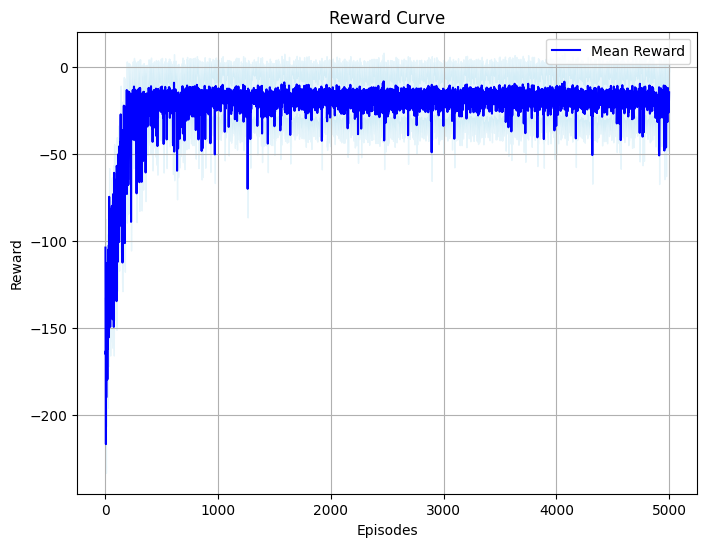

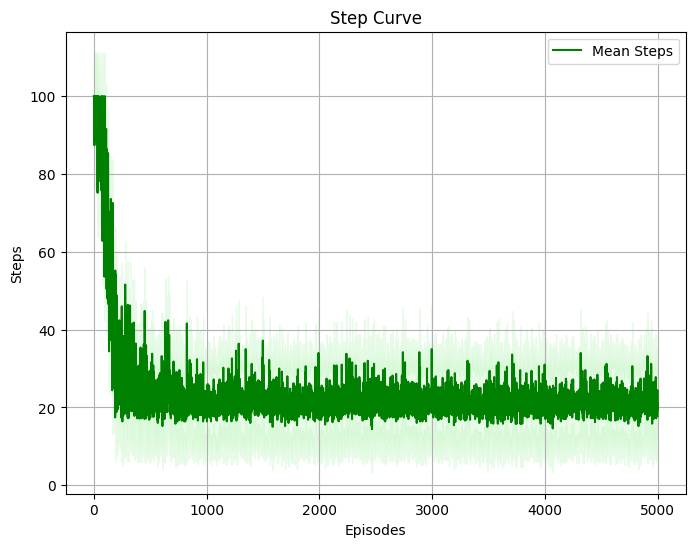

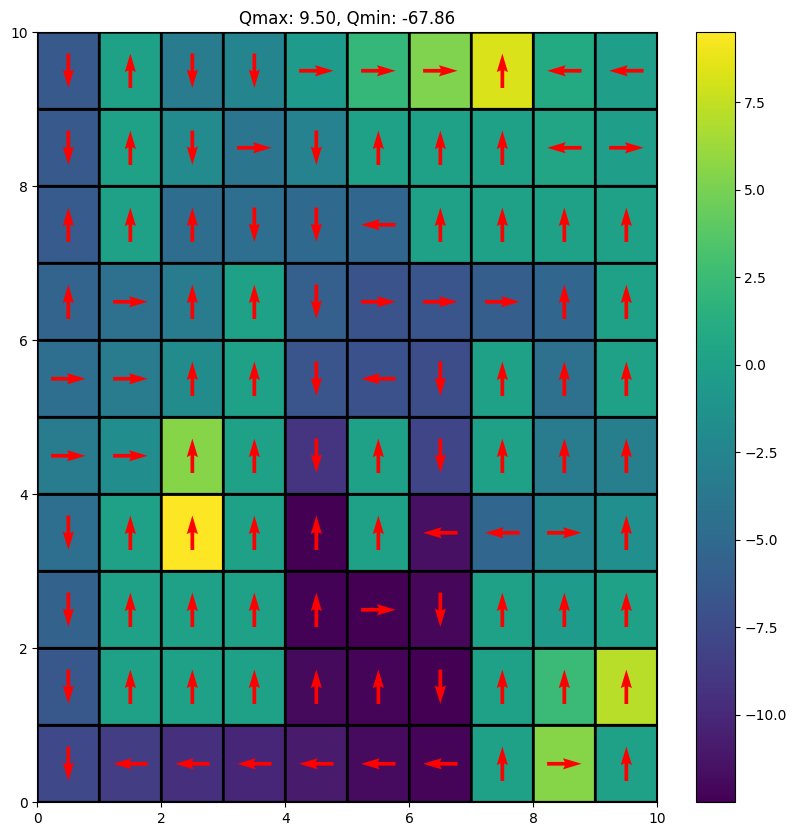

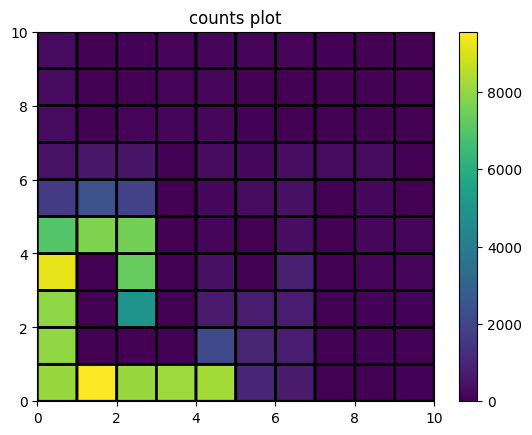

epsilon =  0.08 alpha =  0.12 gamma =  0.99 wind =  True p =  1.0 learning =  qlearning start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 824.64it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 721.28it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 800.73it/s] 


Experiment: 4


100%|██████████| 5000/5000 [00:06<00:00, 726.37it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:06<00:00, 767.56it/s]


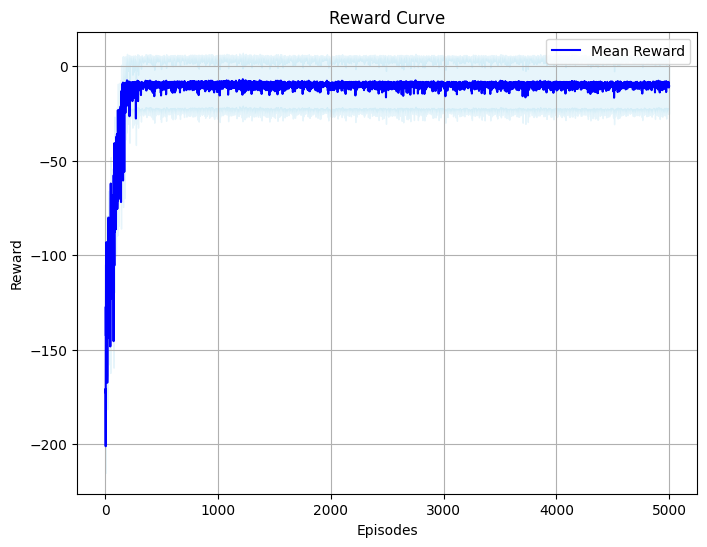

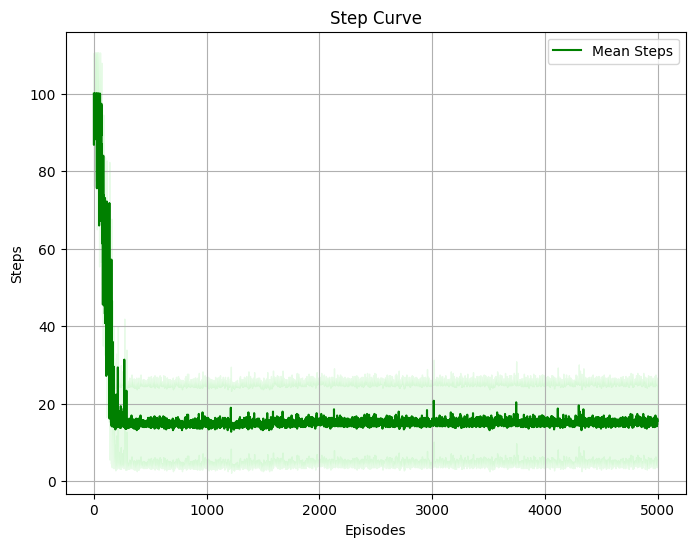

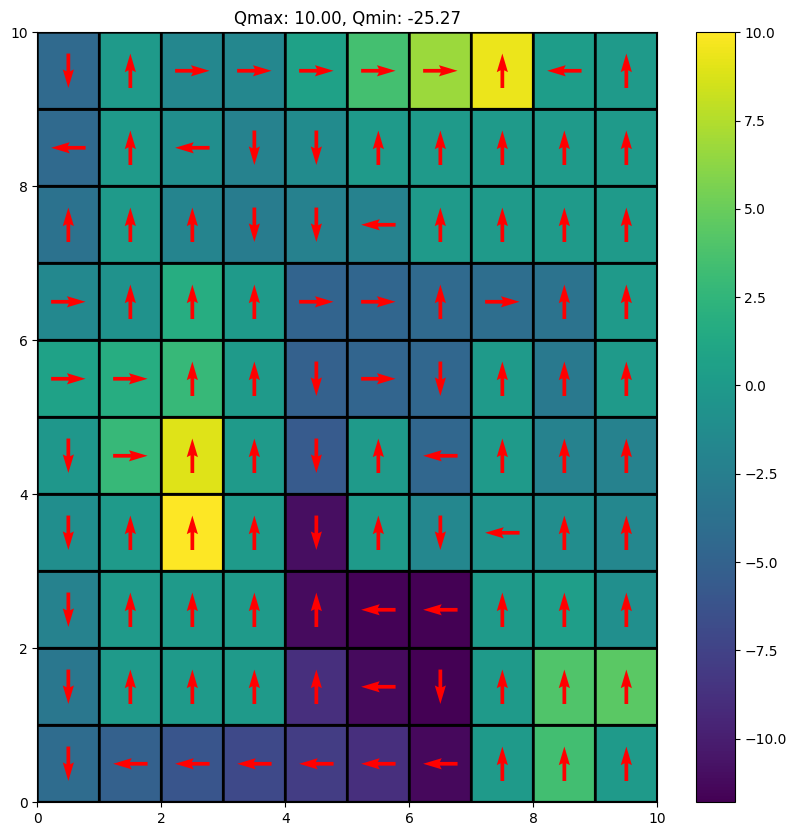

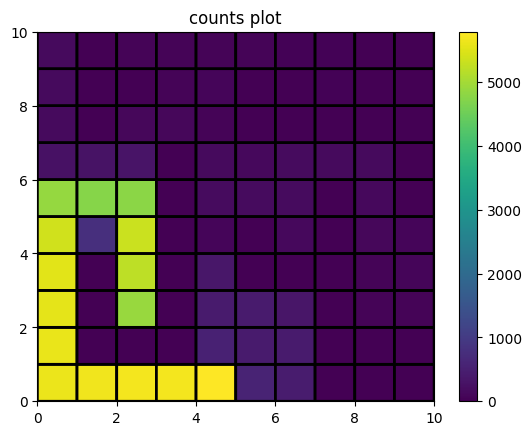

epsilon =  0.08 alpha =  0.1 gamma =  0.97 wind =  False p =  1.0 learning =  sarsa start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 742.29it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 800.11it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 760.32it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:06<00:00, 815.34it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:06<00:00, 732.49it/s]


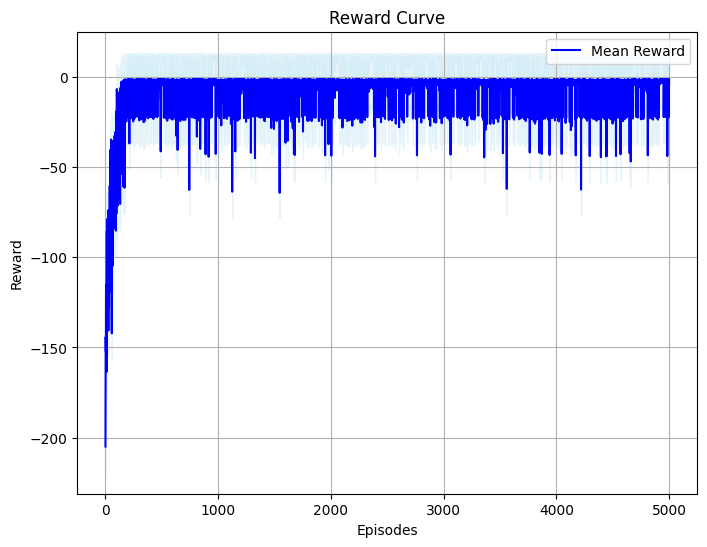

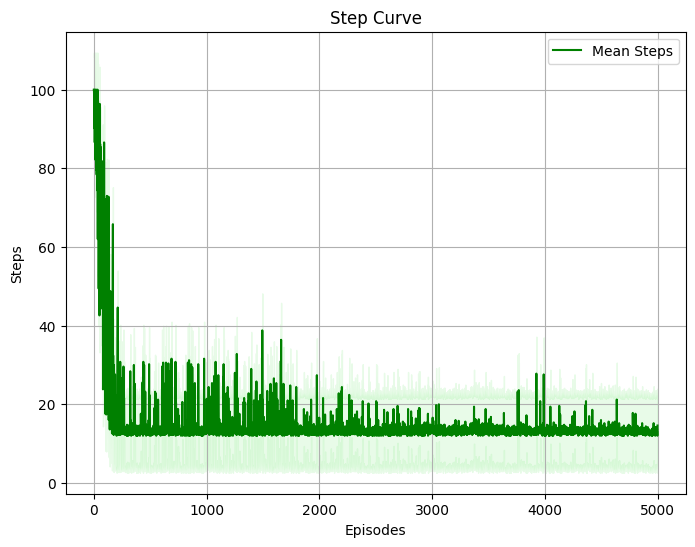

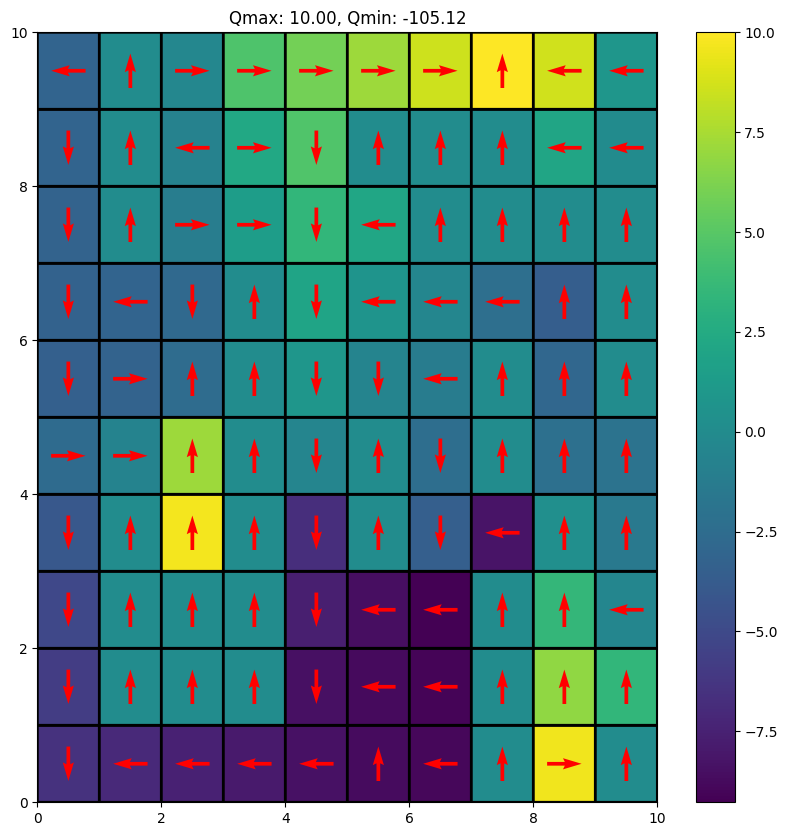

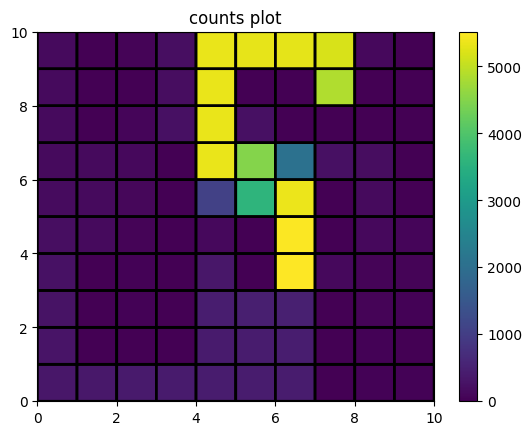

epsilon =  0.08 alpha =  0.12 gamma =  0.97 wind =  False p =  0.7 learning =  sarsa start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 470.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 463.96it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 440.11it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:10<00:00, 479.23it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:10<00:00, 459.67it/s]


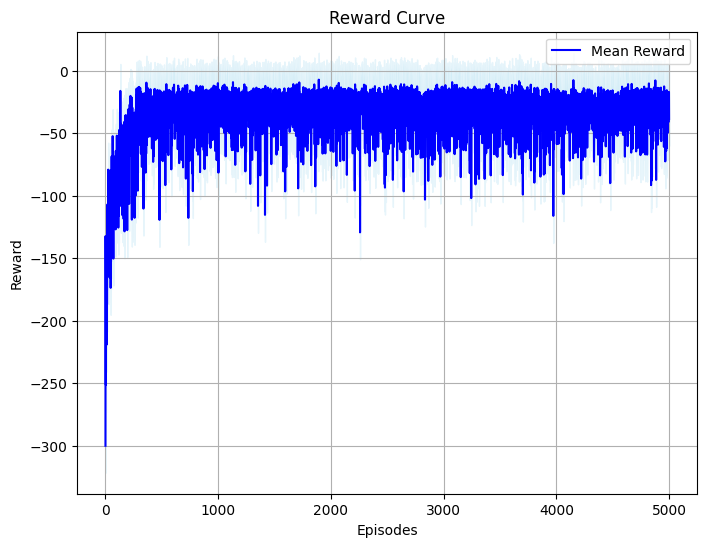

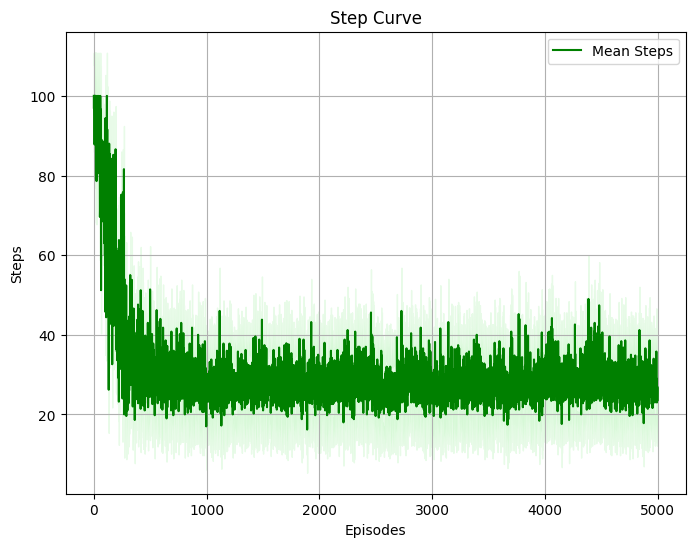

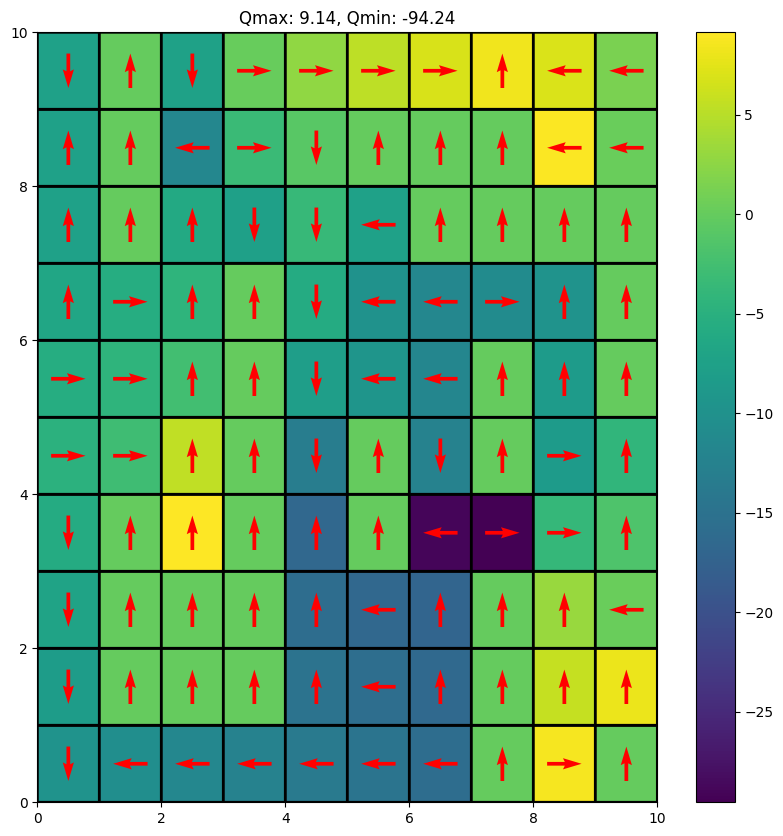

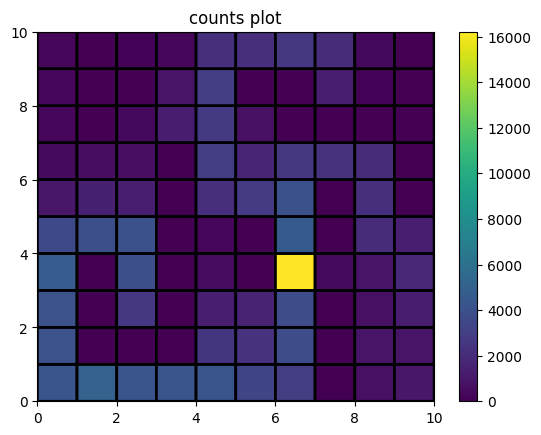

epsilon =  0.08 alpha =  0.1 gamma =  0.99 wind =  True p =  1.0 learning =  sarsa start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 614.56it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 639.84it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 719.82it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 649.06it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:07<00:00, 659.87it/s]


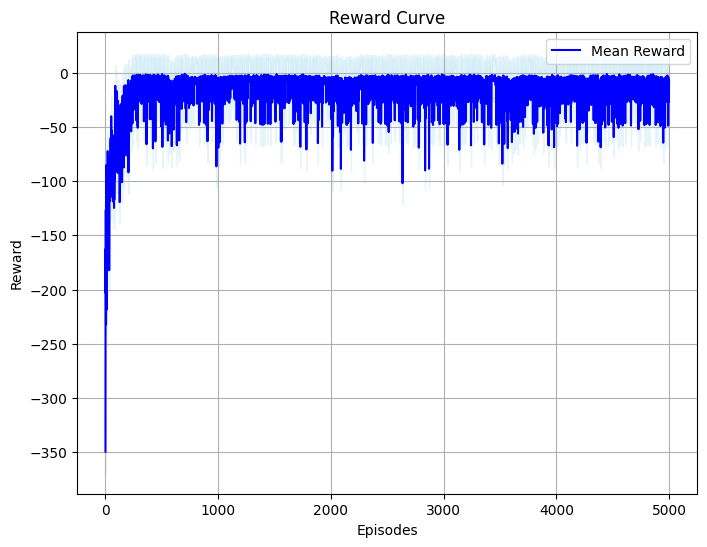

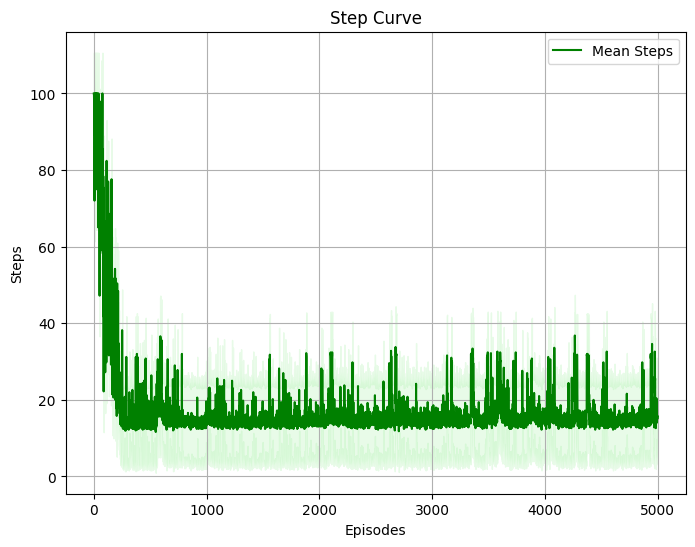

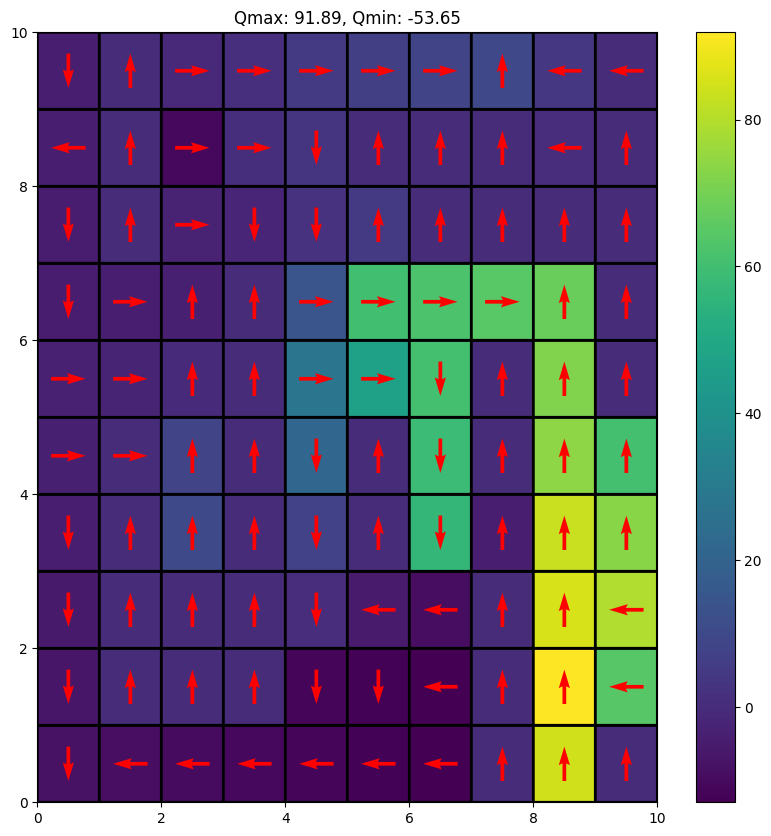

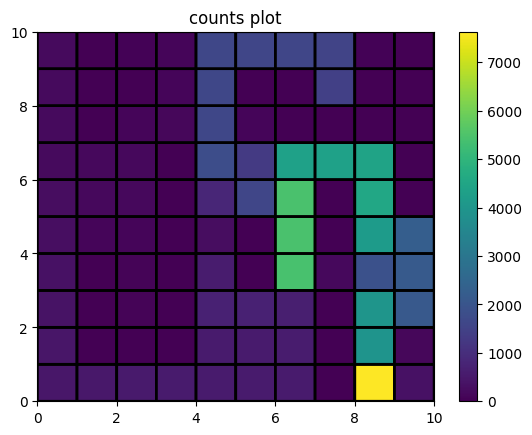

epsilon =  0.08 alpha =  0.12 gamma =  0.99 wind =  False p =  1.0 learning =  qlearning start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 650.14it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 709.90it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 714.37it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 645.38it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:06<00:00, 752.51it/s]


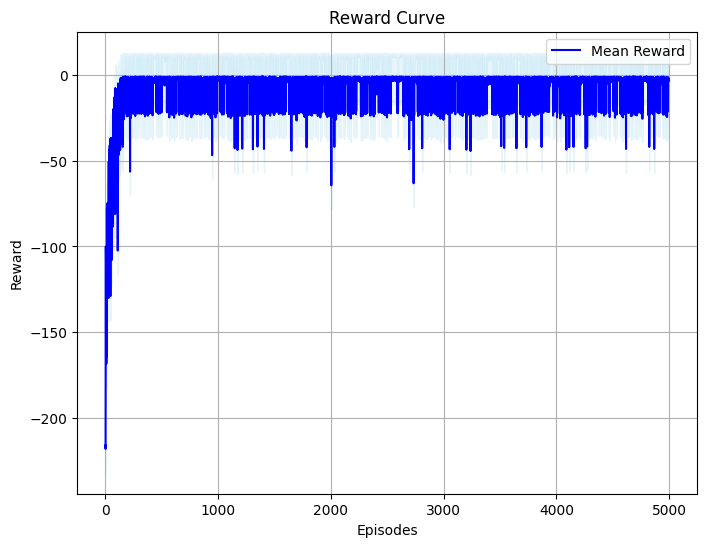

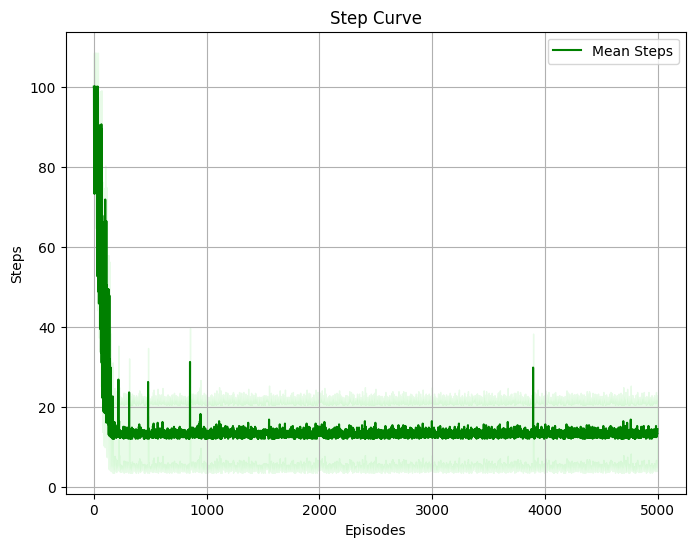

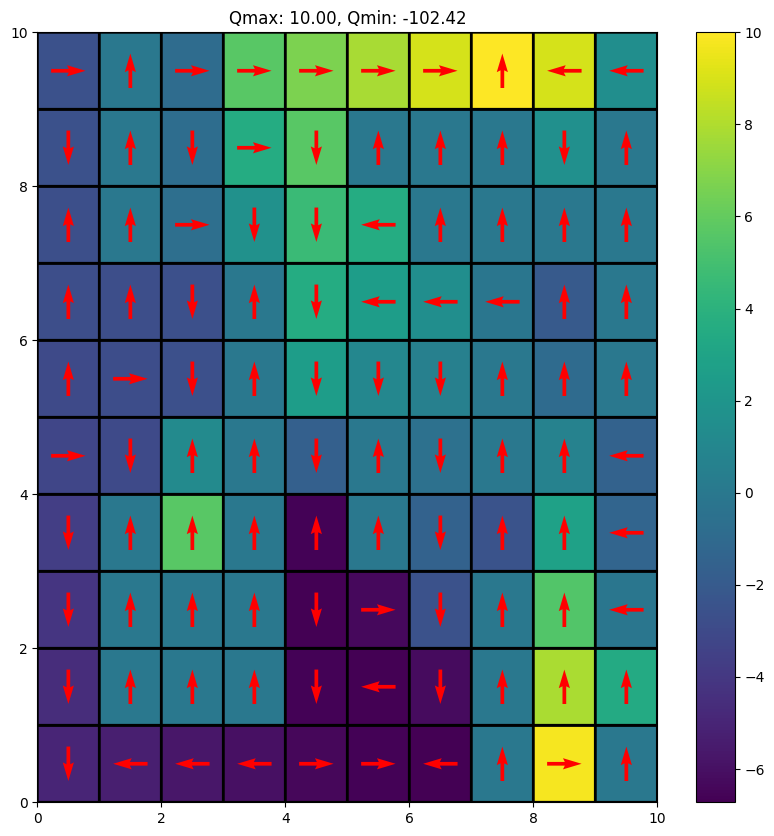

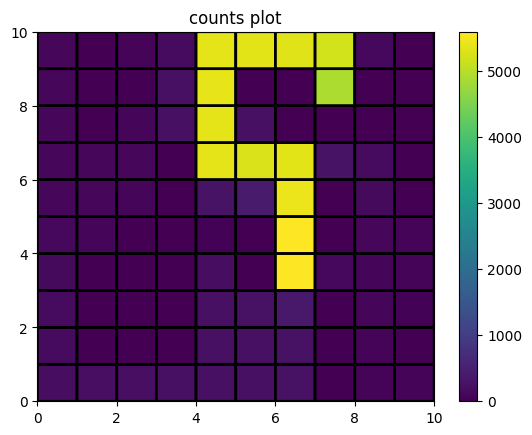

epsilon =  0.08 alpha =  0.12 gamma =  0.99 wind =  False p =  0.7 learning =  qlearning start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 392.91it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 371.68it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:13<00:00, 382.84it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:12<00:00, 406.89it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:12<00:00, 404.62it/s]


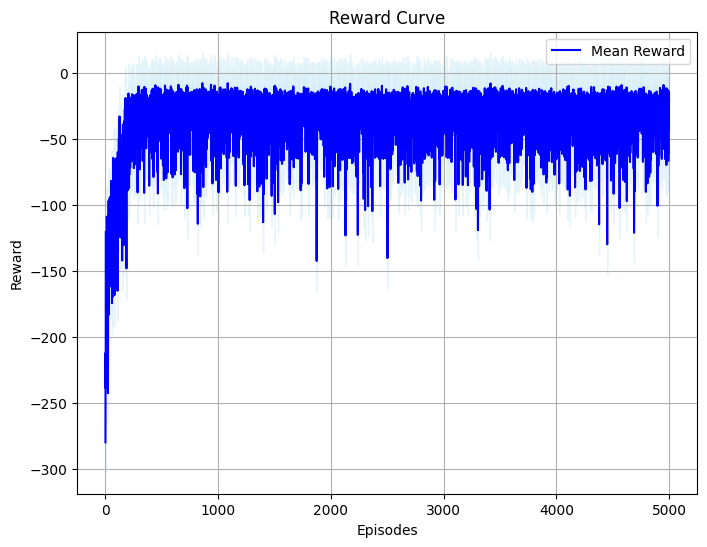

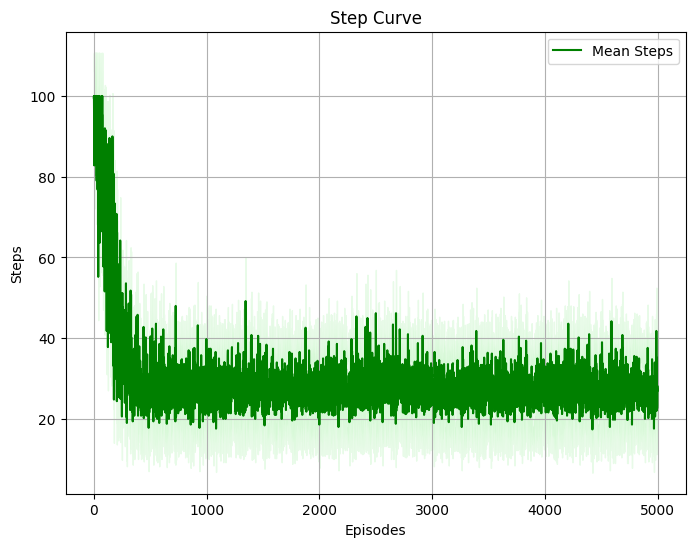

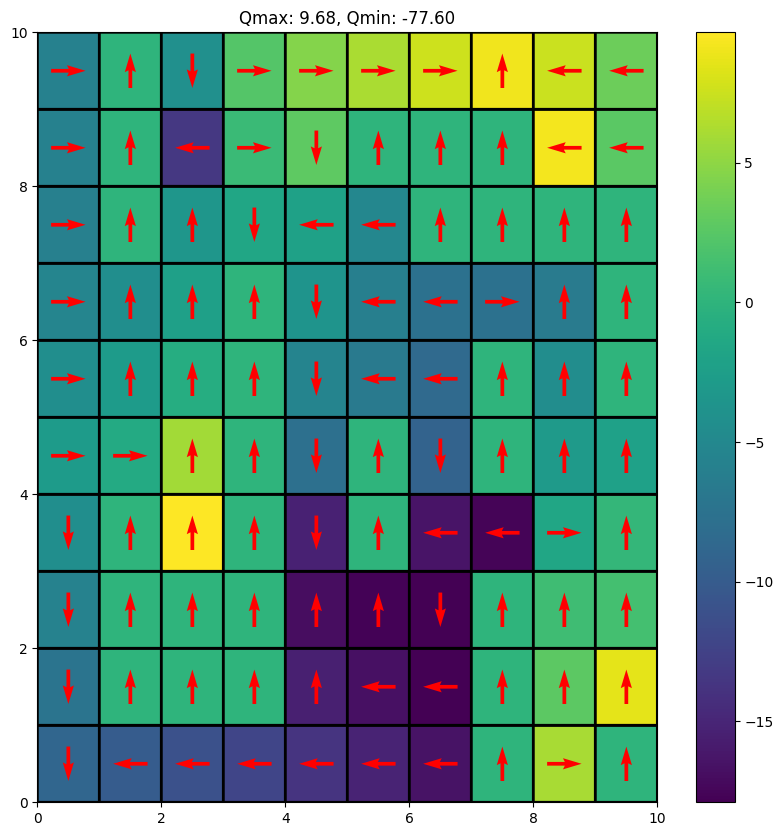

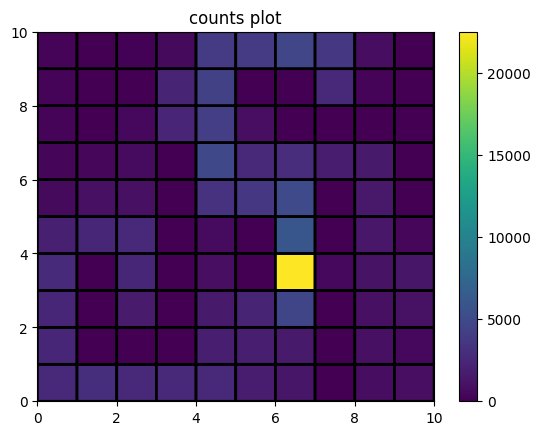

epsilon =  0.08 alpha =  0.08 gamma =  0.99 wind =  True p =  1.0 learning =  qlearning start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 580.26it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 728.01it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 571.44it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 681.21it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:07<00:00, 667.49it/s]


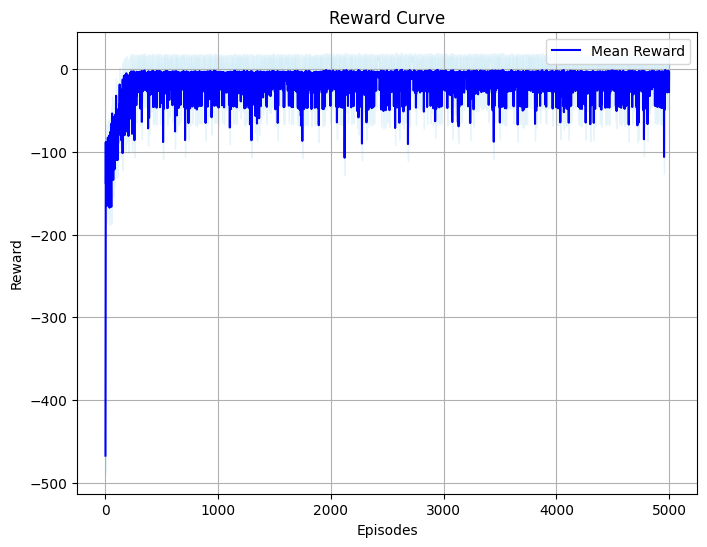

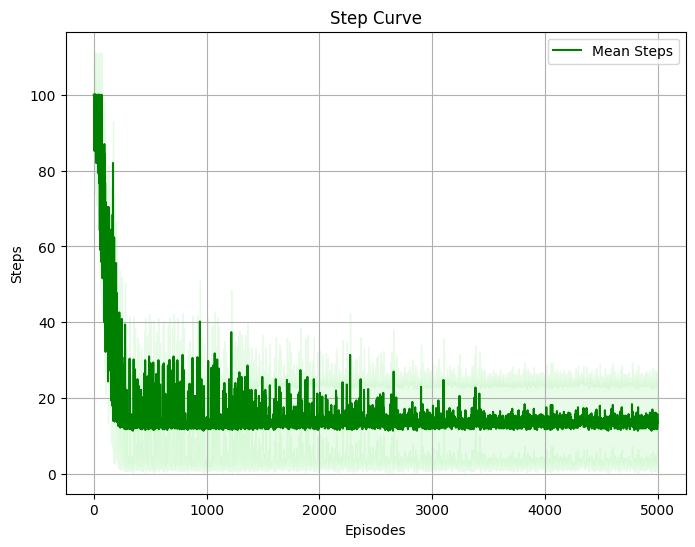

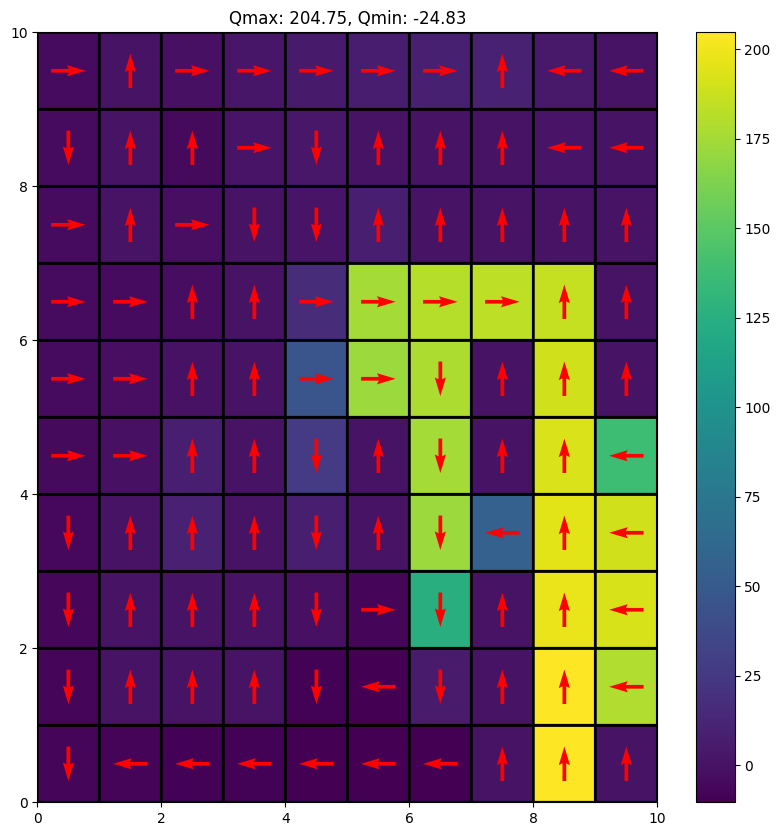

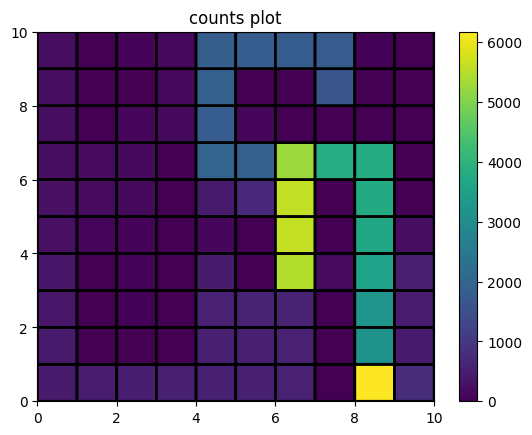

In [36]:
experiment=[[0.08,0.12,0.97,False,1.0,'sarsa',[0,4]],
             [0.08,0.12,0.95,False,0.7,'sarsa',[0,4]],
             [0.08,0.12,0.97,True,1.0,'sarsa',[0,4]],
             [0.08,0.12,0.97,False,1.0,'qlearning',[0,4]],
             [0.08,0.12,0.95,False,0.7,'qlearning',[0,4]],
             [0.08,0.12,0.99,True,1.0,'qlearning',[0,4]],
             [0.08,0.1,0.97,False,1.0,'sarsa',[3,6]],
             [0.08,0.12,0.97,False,0.7,'sarsa',[3,6]],
             [0.08,0.1,0.99,True,1.0,'sarsa',[3,6]],
             [0.08,0.12,0.99,False,1.0,'qlearning',[3,6]],
             [0.08,0.12,0.99,False,0.7,'qlearning',[3,6]],
             [0.08,0.08,0.99,True,1.0,'qlearning',[3,6]],]
for epsilon,alpha,gamma,wind,p,learning,start in experiment:
  print("epsilon = ",epsilon,"alpha = ",alpha,"gamma = ",gamma,"wind = ",wind,"p = ",p,"learning = ",learning,"start = ",start)
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
  restart_states = np.array([[3,7],[8,2]])
  start_state = np.array([start])
  goal_states = np.array([[0,9],[2,2],[8,7]])

  # create model
  gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states, wind = wind)
  gw.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)
  gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
  gw.add_transition_probability(p_good_transition=p,
                                bias=0.5)
  env = gw.create_gridworld()
  reward_avgs, reward_stds, steps_avgs, steps_stds, Q_values_mean, state_visit_avgs = plot(epsilon, alpha, gamma, env, wind, p, learning)


In [37]:
def qlearning_s(env, Q, gamma=0.9, alpha=0.4, tau=0.15, plot_heat=False, choose_action=choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)

    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        st=env.reset()
        state = seq_to_col_row(st,num_cols)[0]


        done = False
        action = choose_action(Q, state, tau)

        k=0
        state_visit_counts[state[0],state[1]]+=1
        while not done:
            state_next, reward, done = env.step(st,action)

            state_next=str(state_next)
            if len(state_next)>1:
              state_next=[int(state_next[0]),int(state_next[1])]
            else:
              state_next=[0,int(state_next)]
            action_next = choose_action(Q,state_next ,tau)
            state_visit_counts[state_next[0],state_next[1]]+=1

            # TODO: update equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[state_next[0], state_next[1]]) - Q[state[0], state[1], action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next
            st=int(str(state[0])+str(state[1]))
            if steps>=100:

              done=True

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                            Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts


In [38]:
def sarsa_s(env, Q, gamma = 0.9,alpha=0.4, tau=0.15, plot_heat = False, choose_action = choose_action_softmax):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)


    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        st=env.reset()
        state = seq_to_col_row(st,num_cols)[0]


        done = False
        action = choose_action(Q, state, tau)

        k=0
        state_visit_counts[state[0],state[1]]+=1
        while not done:
            state_next, reward, done = env.step(st,action)

            state_next=str(state_next)
            if len(state_next)>1:
              state_next=[int(state_next[0]),int(state_next[1])]
            else:
              state_next=[0,int(state_next)]
            action_next = choose_action(Q,state_next ,tau)
            state_visit_counts[state_next[0],state_next[1]]+=1

            # TODO: update equation
            Q[state[0],state[1],action]=Q[state[0],state[1],action]+alpha*(reward+gamma*Q[state_next[0],state_next[1],action_next]-Q[state[0],state[1],action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next
            st=int(str(state[0])+str(state[1]))
            if steps>=100:

              done=True

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                            Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts



In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_s(tau, alpha, gamma, env, wind, p_good_transition, learning_function):
    num_expts = 5
    reward_avgs = []
    steps_avgs = []
    state_visit_avgs=[]
    Q_values_list = []
    env.wind = wind
    print(env.start_state)
    if wind:
        env.add_transition_probability(p_good_transition=1.0, bias=0.5)
    else:
        env.add_transition_probability(p_good_transition=p_good_transition, bias=0.5)

    for i in range(num_expts):
        print("Experiment: %d" % (i + 1))
        Q = np.zeros((env.num_rows, env.num_cols, 4))
        rg = np.random.RandomState(i)
        if learning_function == 'sarsa':
            Q_result, rewards, steps,state_visit = sarsa_s(env, Q.copy(), gamma=gamma, alpha=alpha, tau=tau, plot_heat=False,
                                              choose_action=choose_action_softmax)
        elif learning_function == 'qlearning':
            Q_result, rewards, steps,state_visit = qlearning_s(env, Q.copy(), gamma=gamma, alpha=alpha, tau=tau,
                                                  plot_heat=False, choose_action=choose_action_softmax)
        reward_avgs.append(rewards)
        steps_avgs.append(steps)
        state_visit_avgs.append(state_visit)
        Q_values_list.append(Q_result)
    Q_values_mean = np.mean(Q_values_list, axis=0)

    reward_avgs = np.mean(reward_avgs, axis=0)
    reward_stds = np.std(reward_avgs, axis=0)
    steps_avgs = np.mean(steps_avgs, axis=0)
    steps_stds = np.std(steps_avgs, axis=0)
    state_visit_avgs = np.mean(state_visit_avgs, axis=0)


    plot_reward_curve(reward_avgs, reward_stds)
    plot_step_curve(steps_avgs, steps_stds)


    plot_Q(Q_values_mean,message= "Qmax: %.2f, Qmin: %.2f"%( Q_values_mean.max(), Q_values_mean.min()))
    plot_counts(state_visit_avgs, message="counts plot")
    return reward_avgs, reward_stds, steps_avgs, steps_stds, Q_values_mean, state_visit_avgs

tau =  0.1 alpha =  0.14 gamma =  0.99 wind =  False p =  1.0 learning =  sarsa start =  [0, 4]
[[0 4]]
Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-24-4f035c3d5aef>:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self.start_state_seq)
<ipython-input-38-eeb248d7ee4b>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state[0],state[1],action]=Q[state[0],state[1],action]+alpha*(reward+gamma*Q[state_next[0],state_next[1],action_next]-Q[state[0],state[1],action])
<ipython-input-38-eeb248d7ee4b>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  e

Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 674.50it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 759.03it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:08<00:00, 607.75it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:07<00:00, 708.05it/s]


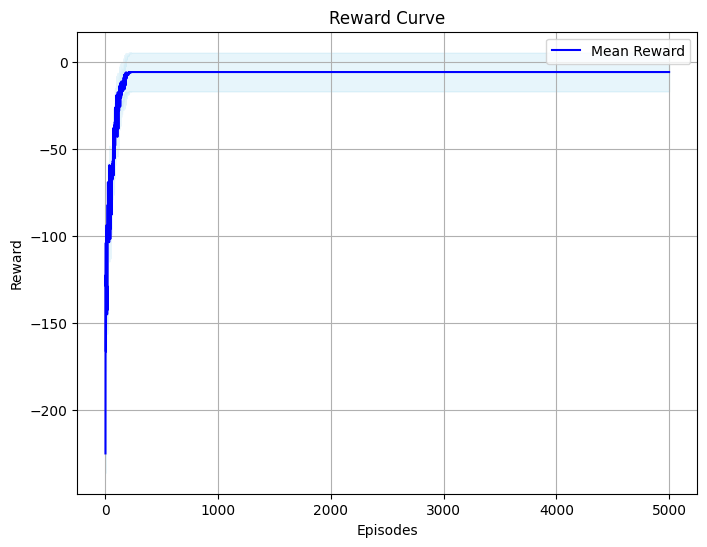

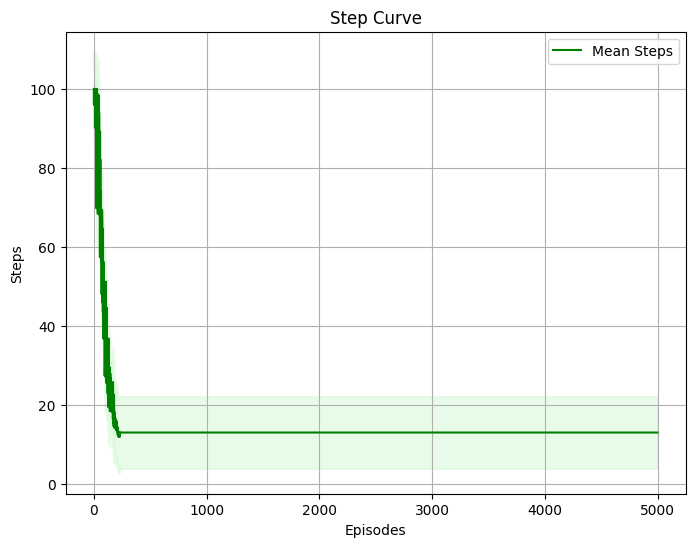

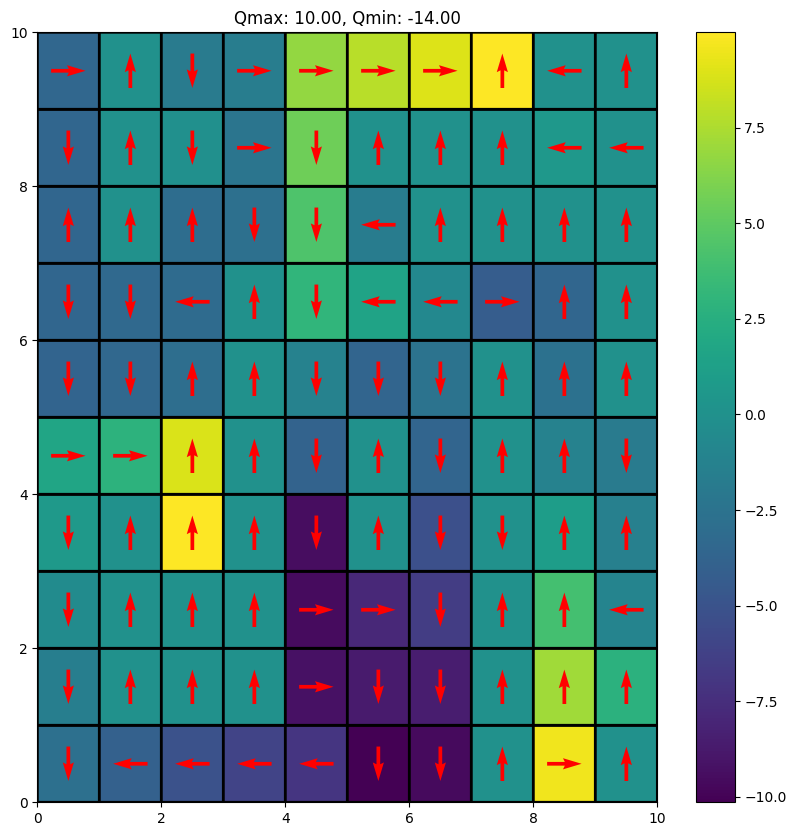

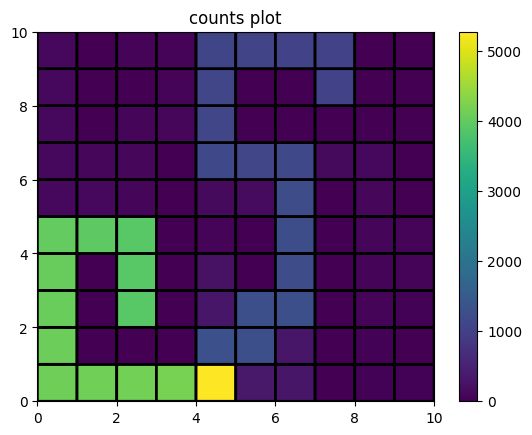

tau =  0.15 alpha =  0.14 gamma =  0.99 wind =  False p =  0.7 learning =  sarsa start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 408.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 456.00it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 433.23it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:11<00:00, 427.52it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:11<00:00, 426.00it/s]


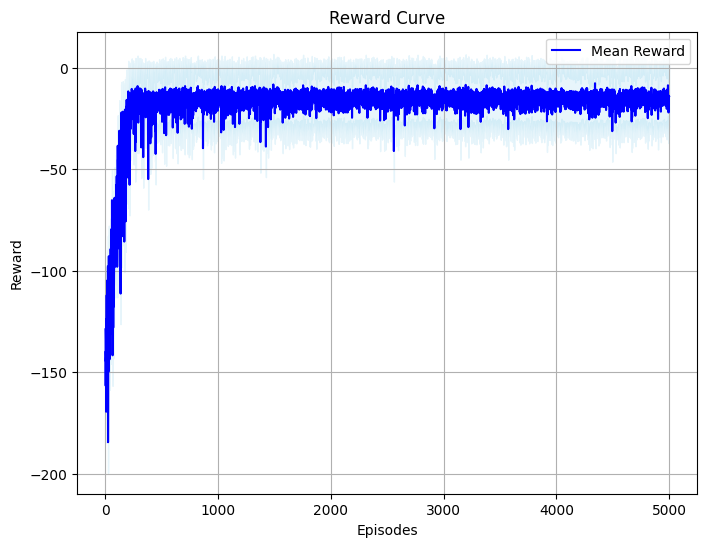

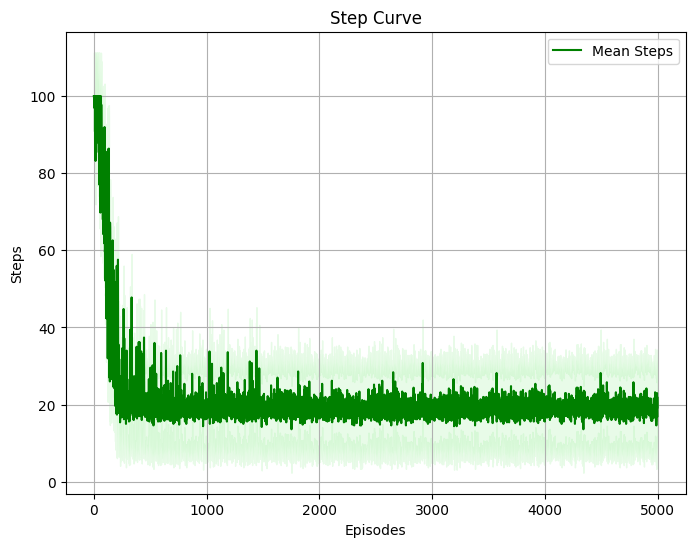

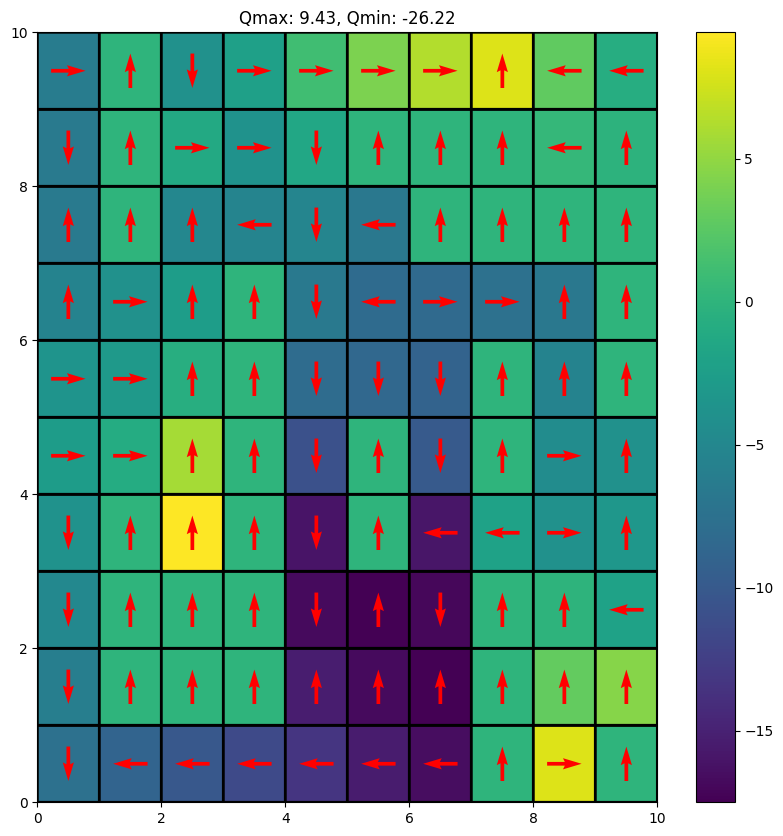

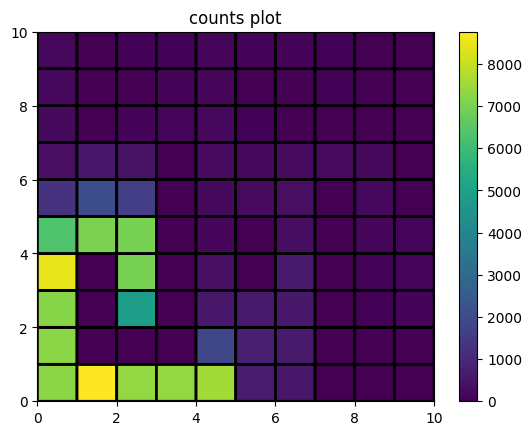

tau =  0.1 alpha =  0.14 gamma =  0.99 wind =  True p =  1.0 learning =  sarsa start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 575.03it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 530.11it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 691.46it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 625.47it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:07<00:00, 636.45it/s]


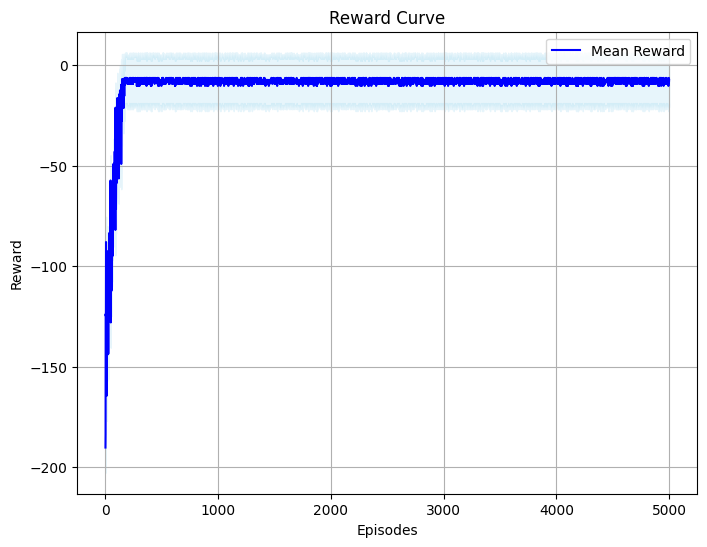

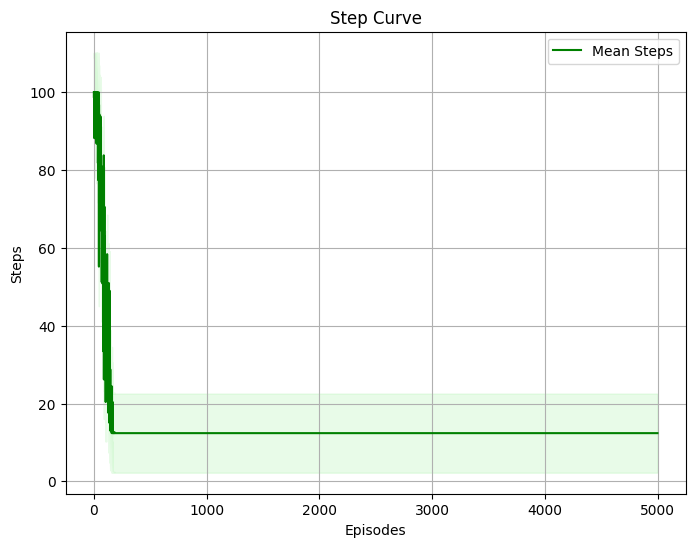

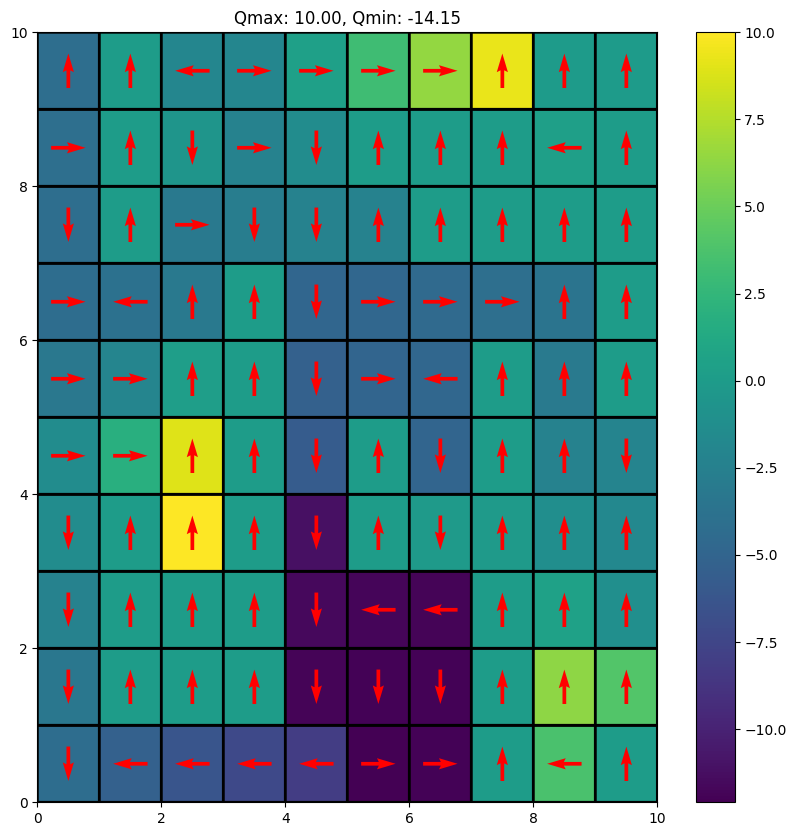

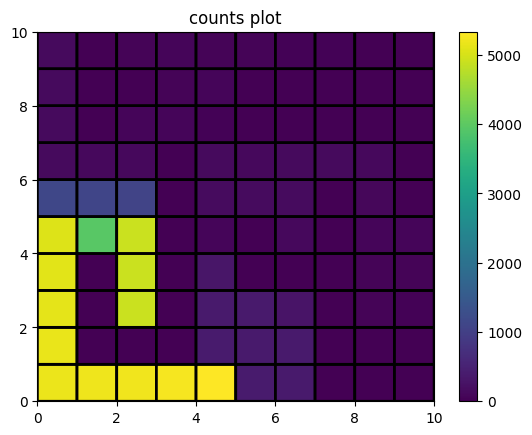

tau =  0.1 alpha =  0.14 gamma =  0.99 wind =  False p =  1.0 learning =  qlearning start =  [0, 4]
[[0 4]]
Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-37-290800999b80>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[state_next[0], state_next[1]]) - Q[state[0], state[1], action])
<ipython-input-37-290800999b80>:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  episode_rewards[ep] = tot_reward
100%|██████████| 5000/5000 [00:07<00:00, 684.22it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 590.30it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 532.95it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:07<00:00, 653.98it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:08<00:00, 614.47it/s]


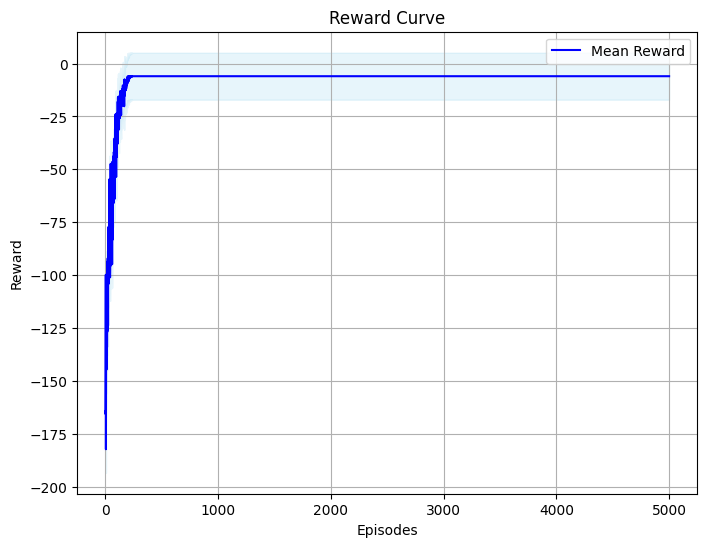

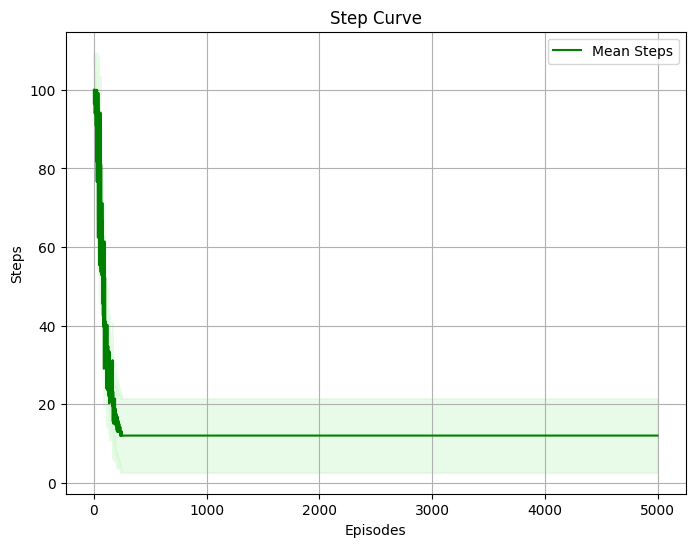

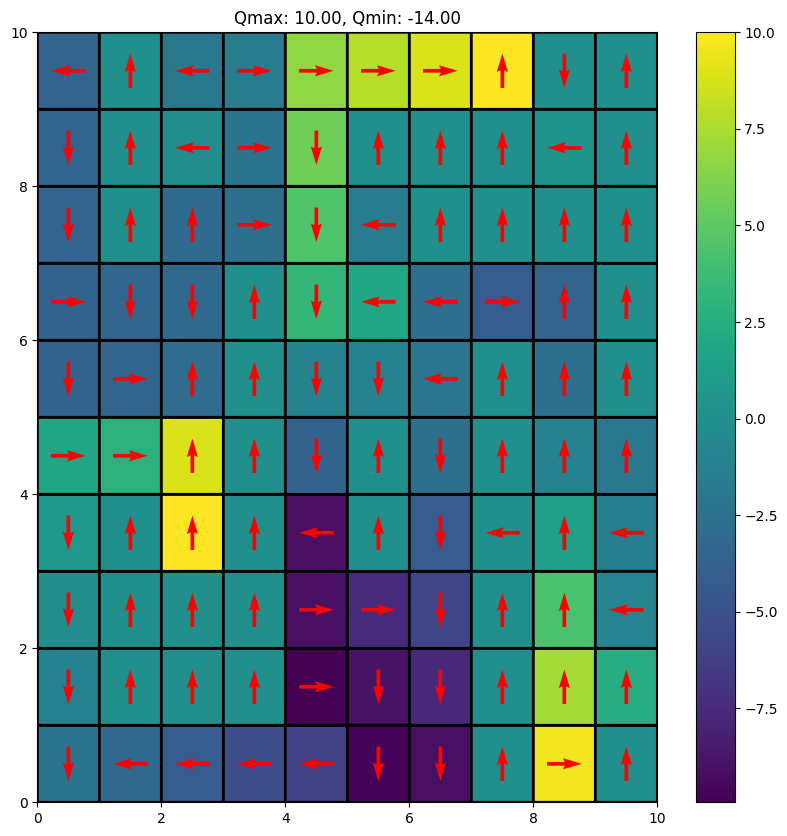

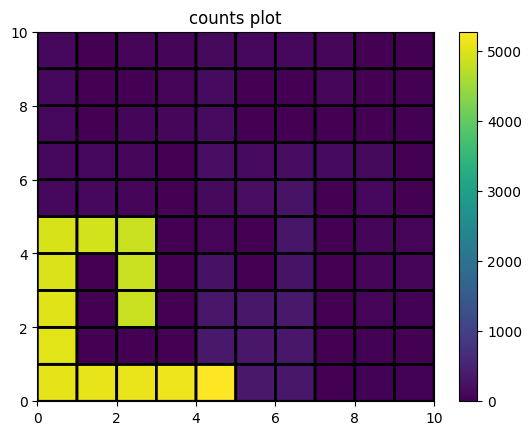

tau =  0.1 alpha =  0.14 gamma =  0.99 wind =  False p =  0.7 learning =  qlearning start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 387.65it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 376.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 410.98it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:12<00:00, 406.59it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:12<00:00, 387.13it/s]


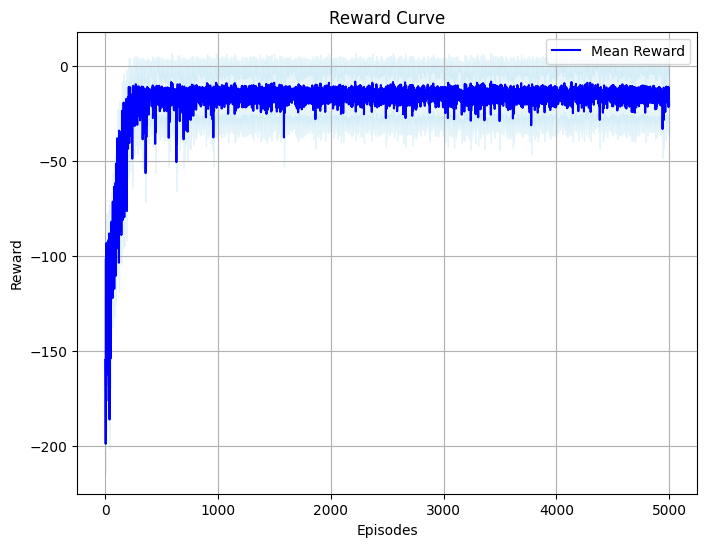

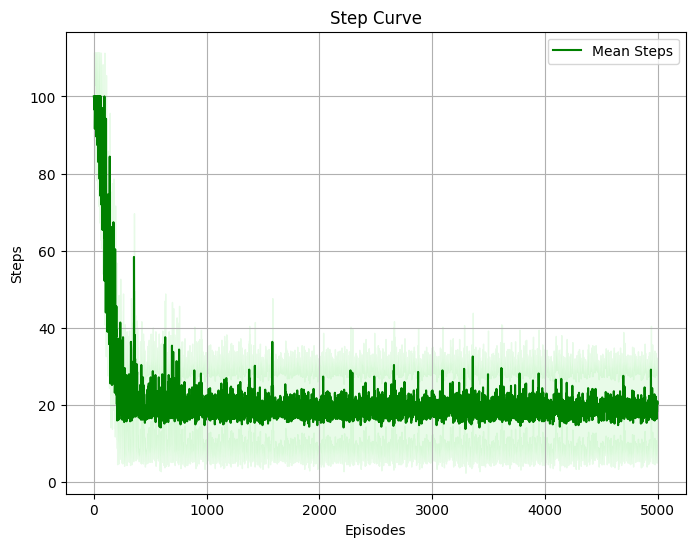

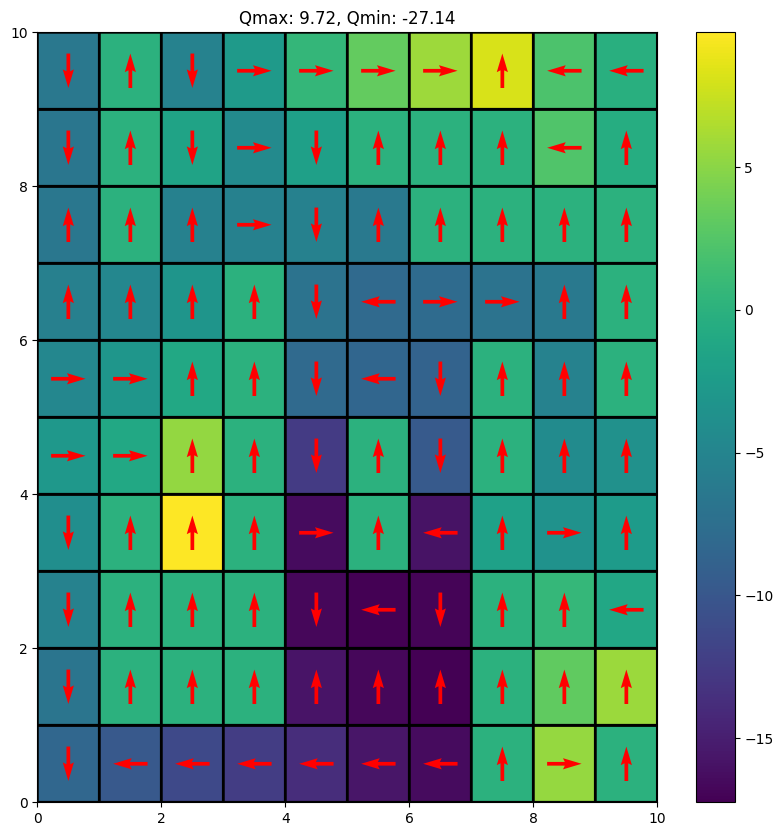

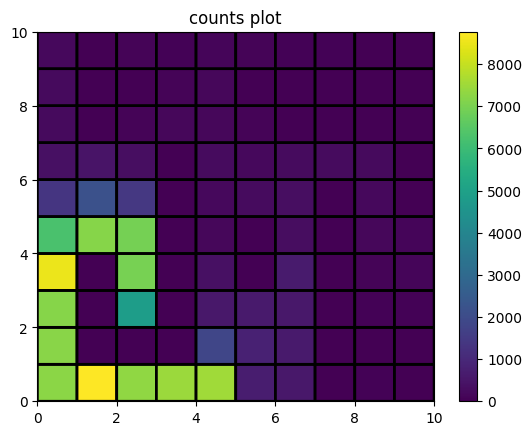

tau =  0.1 alpha =  0.1 gamma =  0.99 wind =  True p =  1.0 learning =  qlearning start =  [0, 4]
[[0 4]]
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 432.15it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 566.33it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 533.08it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:11<00:00, 432.94it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:09<00:00, 526.98it/s]


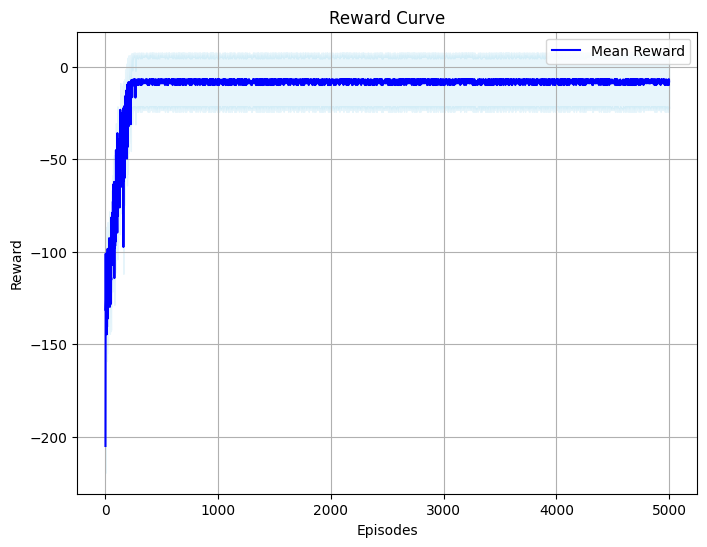

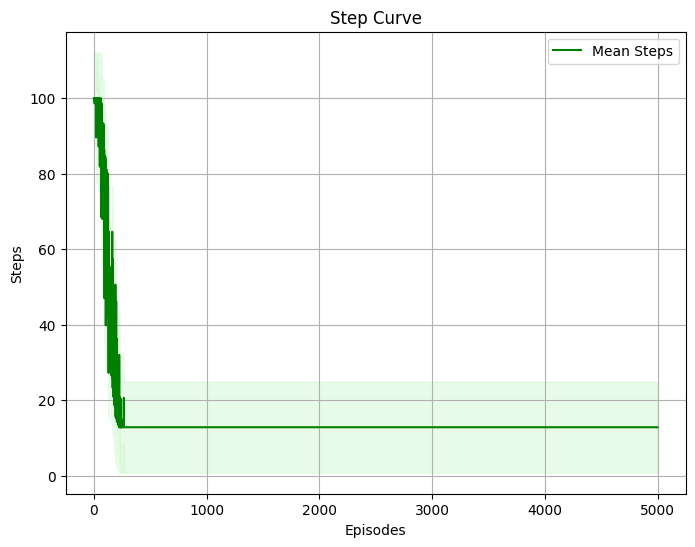

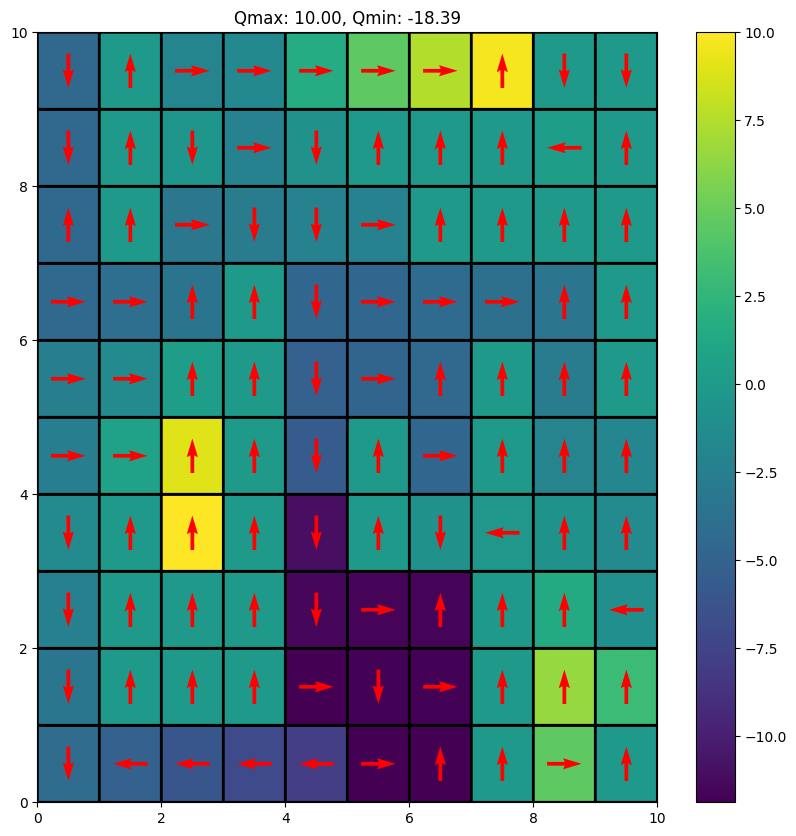

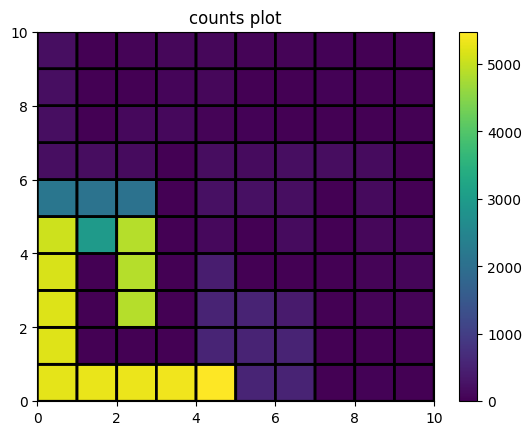

tau =  0.1 alpha =  0.12 gamma =  0.99 wind =  False p =  1.0 learning =  sarsa start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 492.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 551.49it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:10<00:00, 491.73it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:09<00:00, 514.30it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:09<00:00, 522.56it/s]


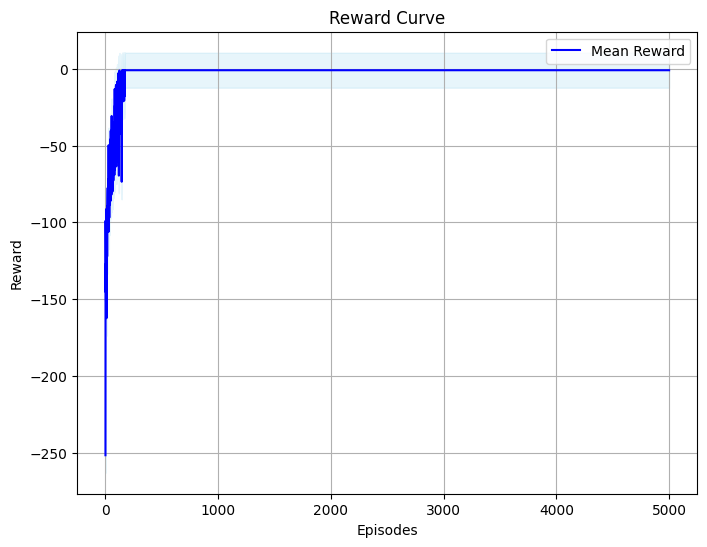

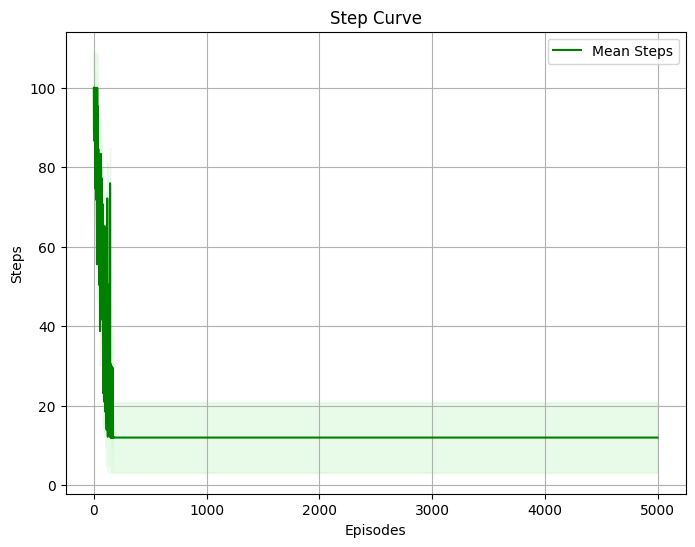

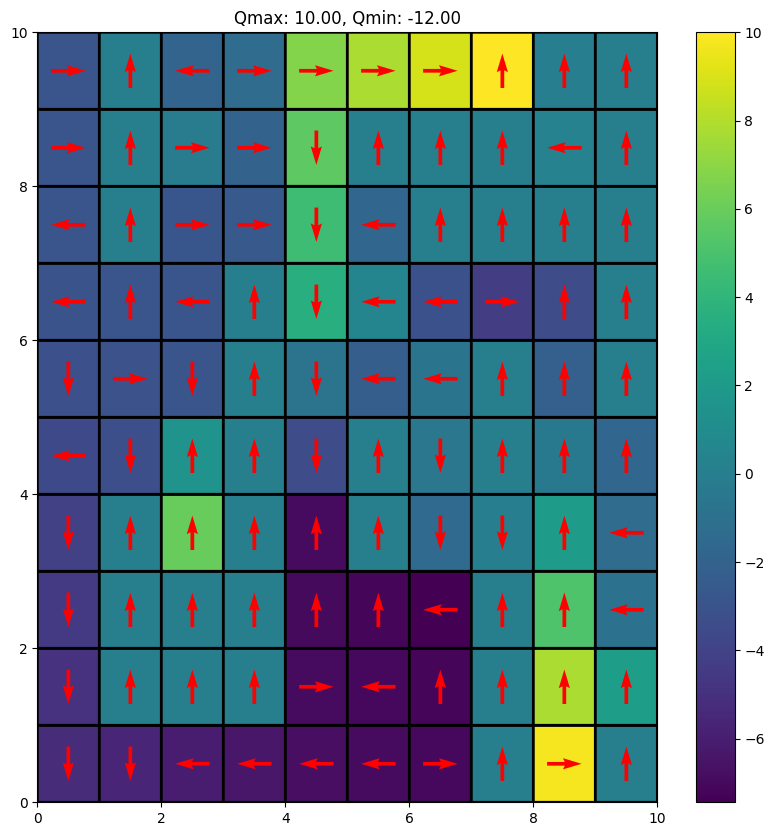

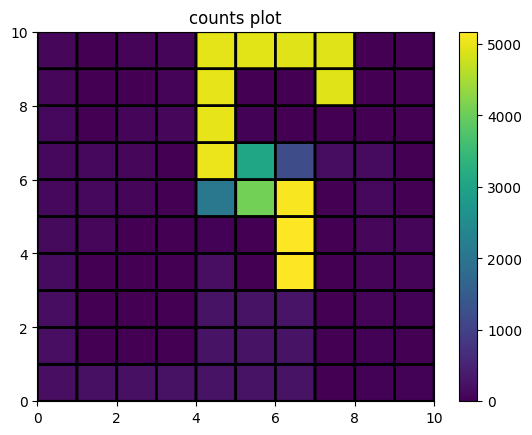

tau =  0.2 alpha =  0.1 gamma =  0.99 wind =  False p =  0.7 learning =  sarsa start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 286.72it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:19<00:00, 257.46it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:18<00:00, 270.69it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:17<00:00, 286.98it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:17<00:00, 279.14it/s]


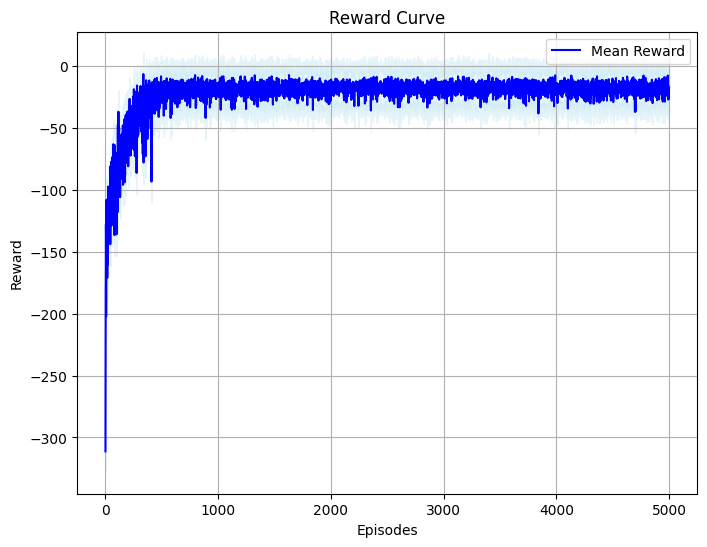

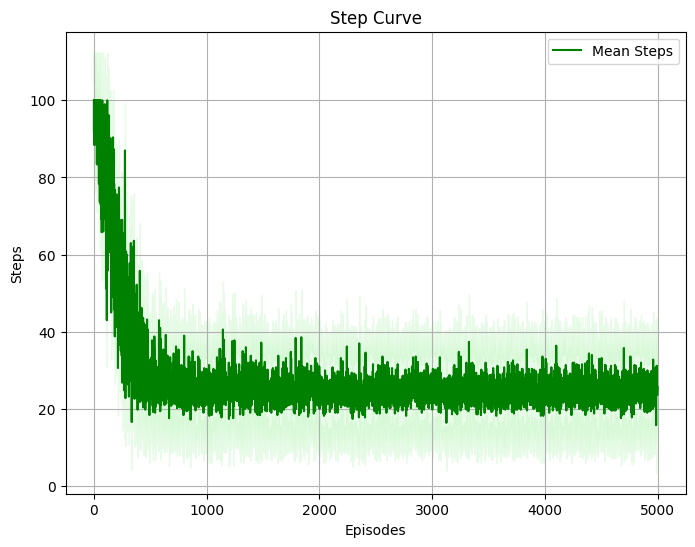

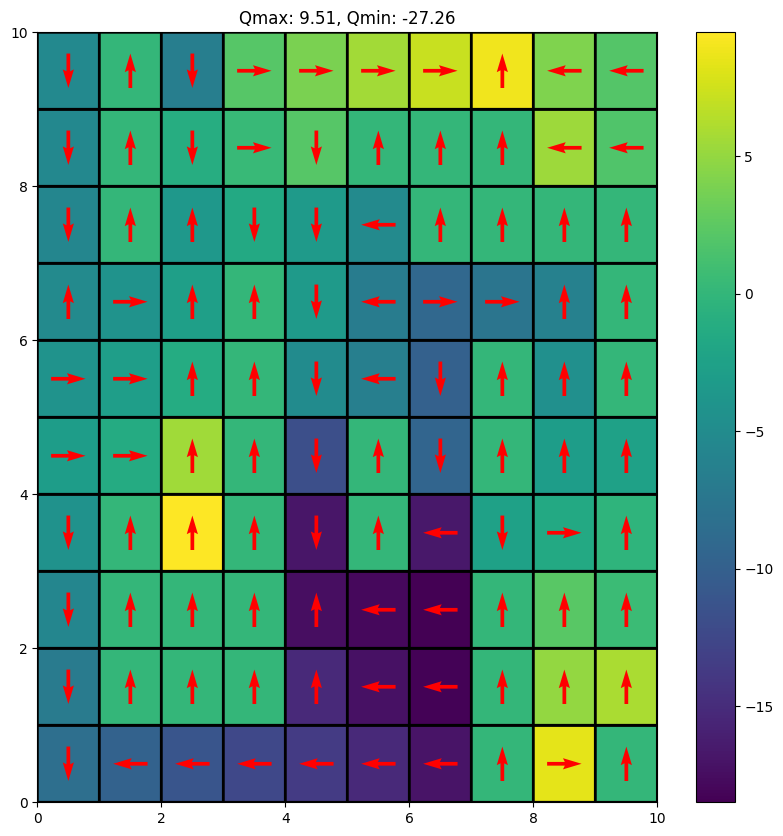

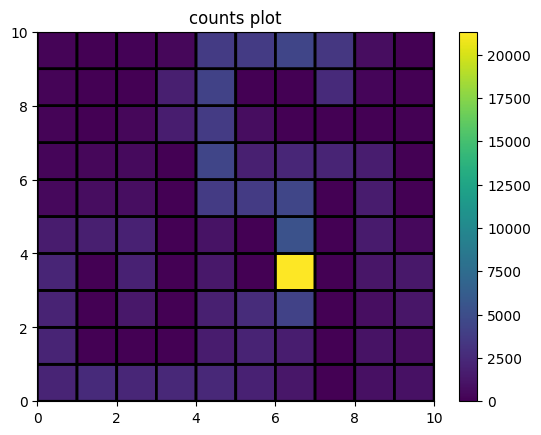

tau =  0.15 alpha =  0.1 gamma =  0.93 wind =  True p =  1.0 learning =  sarsa start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 573.24it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 525.90it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 533.34it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:09<00:00, 522.62it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:09<00:00, 522.00it/s]


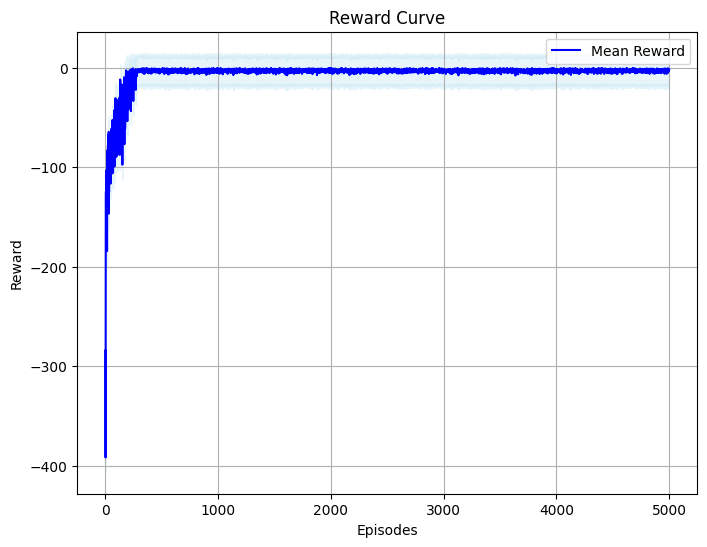

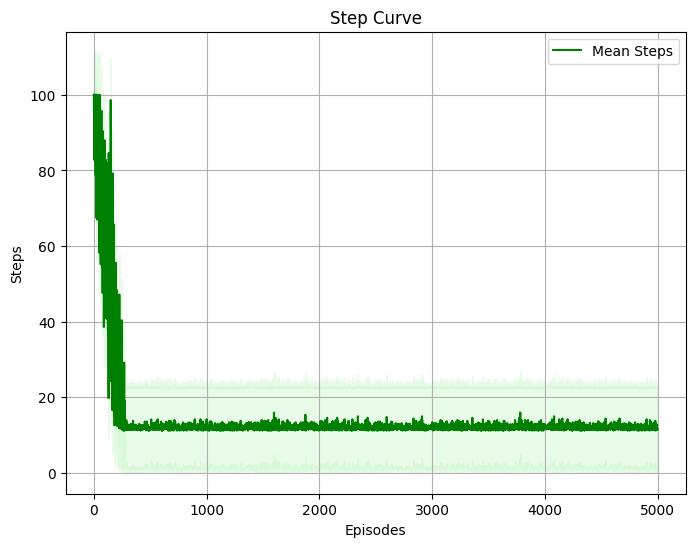

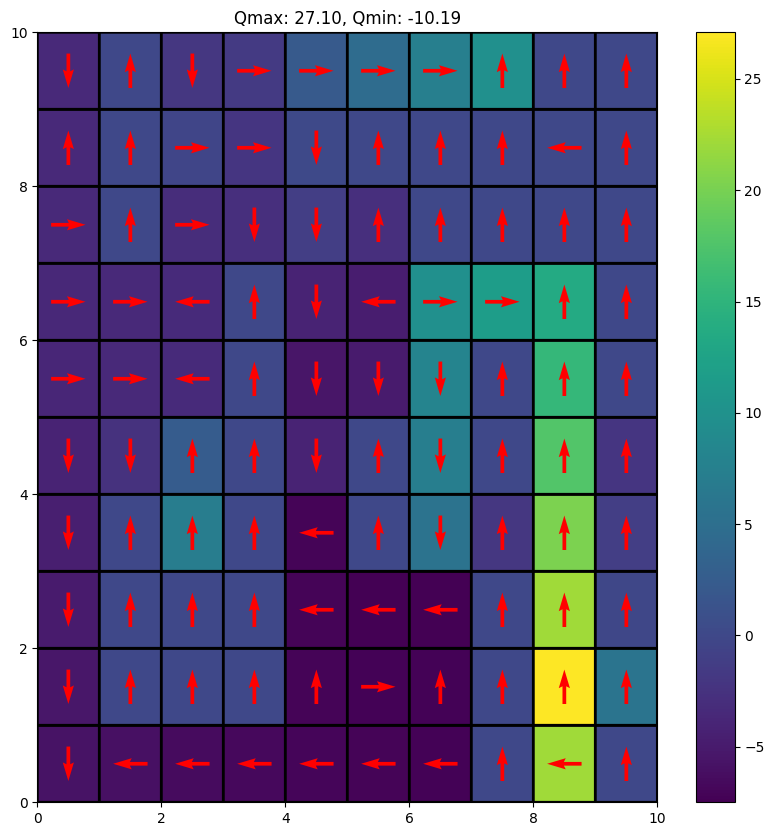

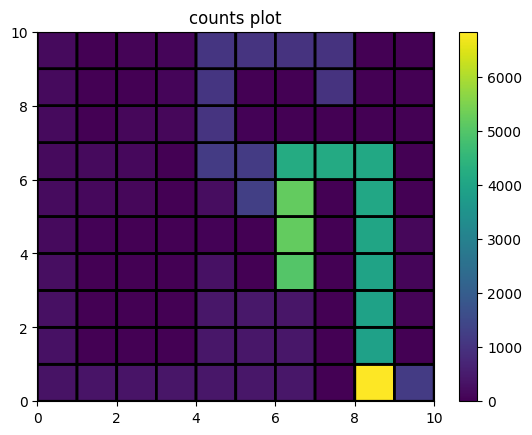

tau =  0.2 alpha =  0.1 gamma =  0.99 wind =  False p =  1.0 learning =  qlearning start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 495.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 489.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:10<00:00, 486.52it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:10<00:00, 486.16it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:09<00:00, 531.57it/s]


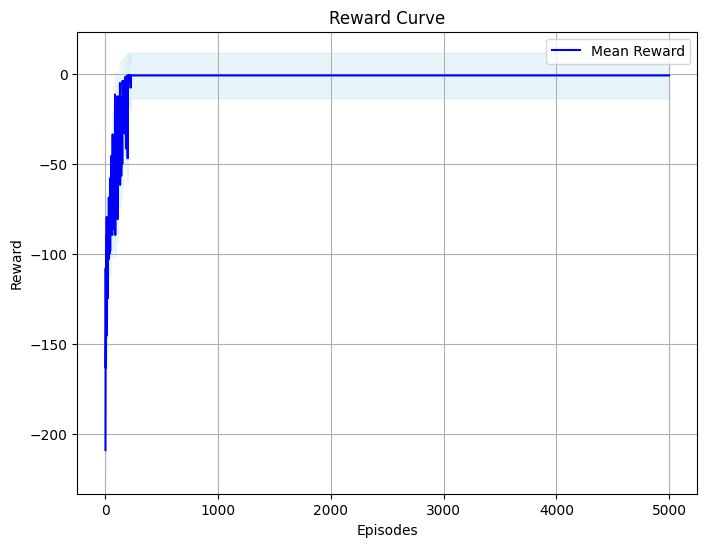

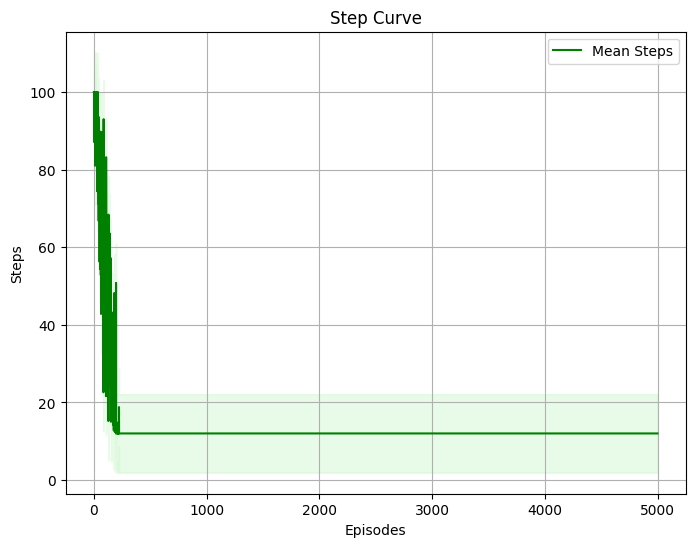

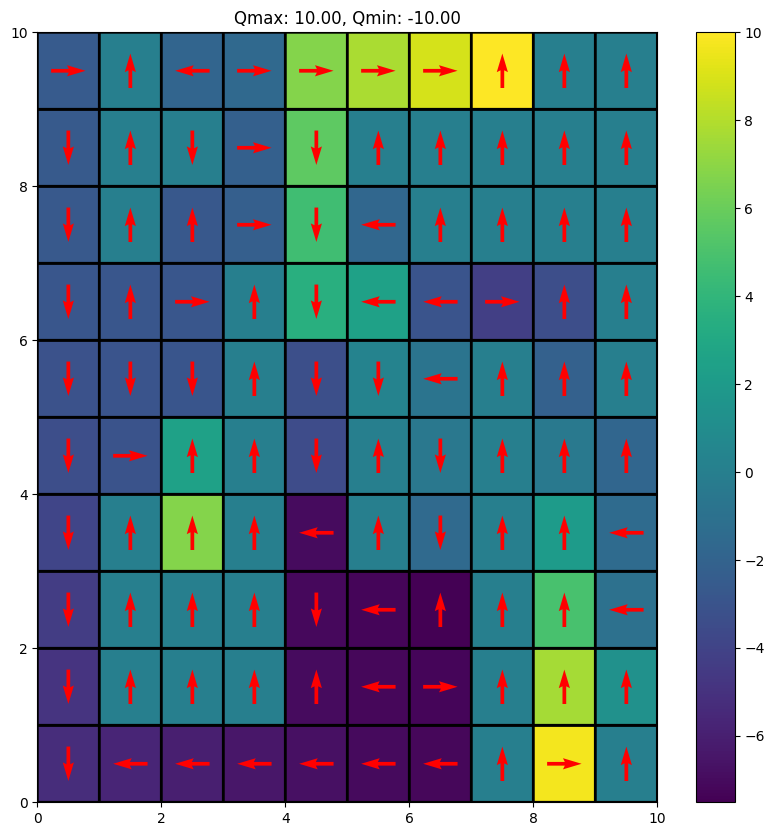

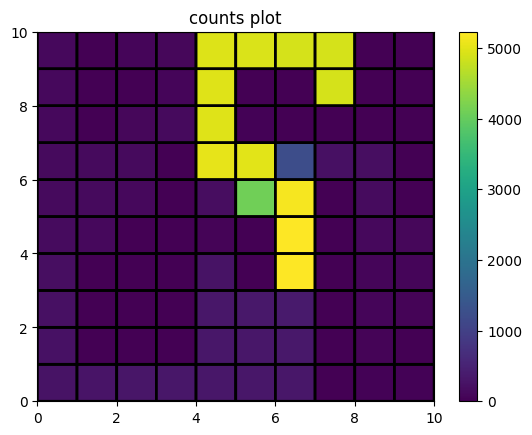

tau =  0.2 alpha =  0.1 gamma =  0.99 wind =  False p =  0.7 learning =  qlearning start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 254.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:18<00:00, 264.33it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:20<00:00, 248.91it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:18<00:00, 275.85it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:19<00:00, 251.73it/s]


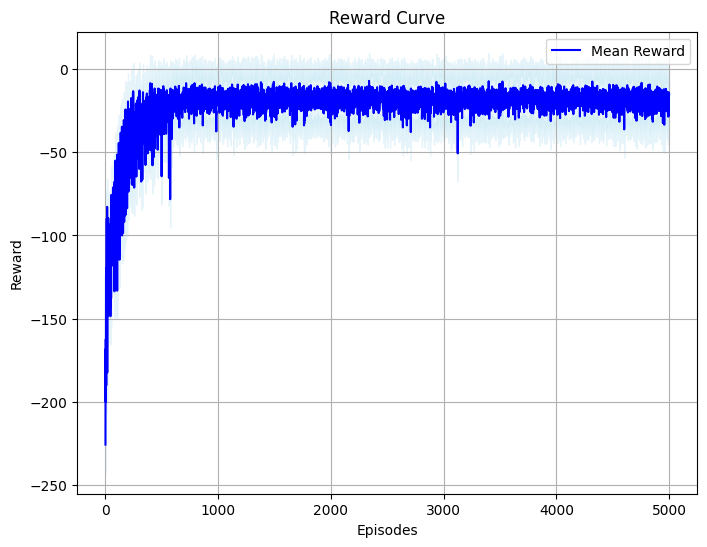

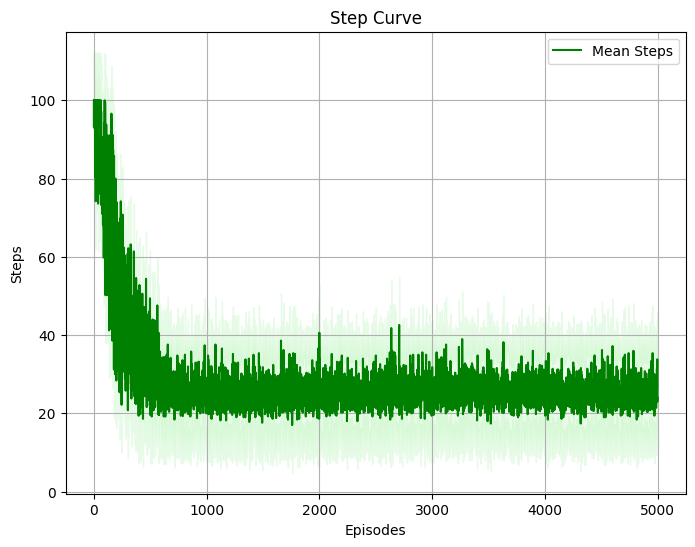

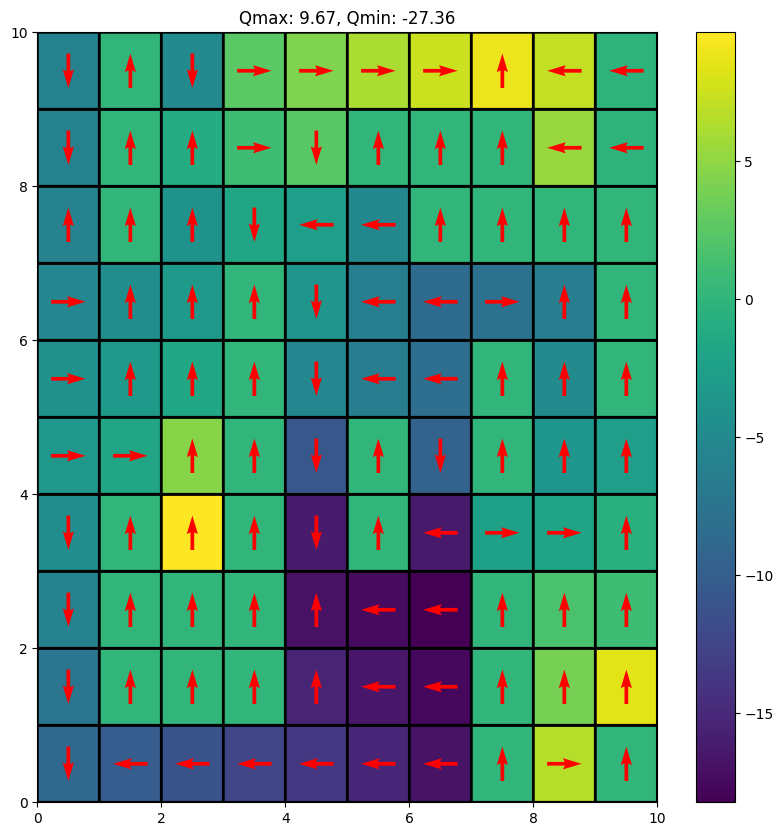

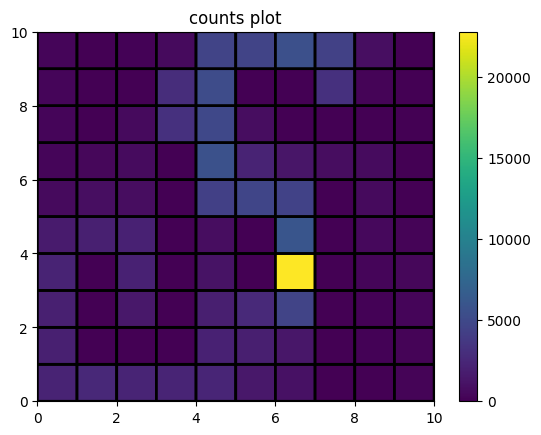

tau =  0.1 alpha =  0.12 gamma =  0.99 wind =  True p =  1.0 learning =  qlearning start =  [3, 6]
[[3 6]]
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 526.09it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 548.50it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 502.64it/s]


Experiment: 4


100%|██████████| 5000/5000 [00:10<00:00, 479.87it/s]


Experiment: 5


100%|██████████| 5000/5000 [00:09<00:00, 516.41it/s]


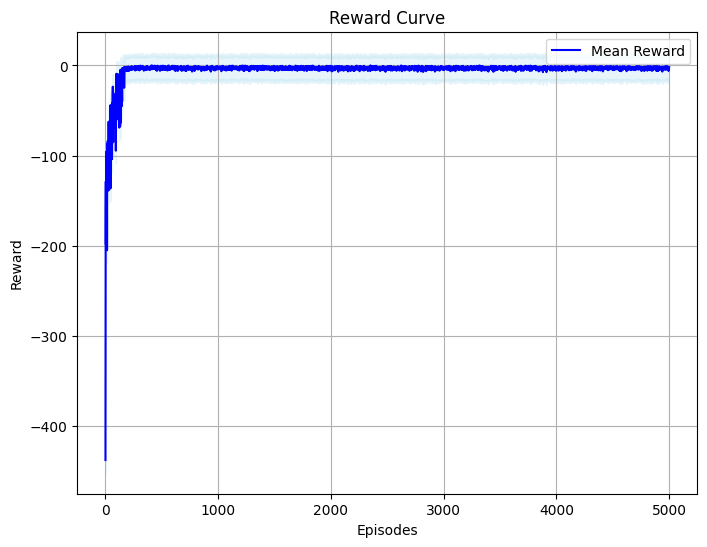

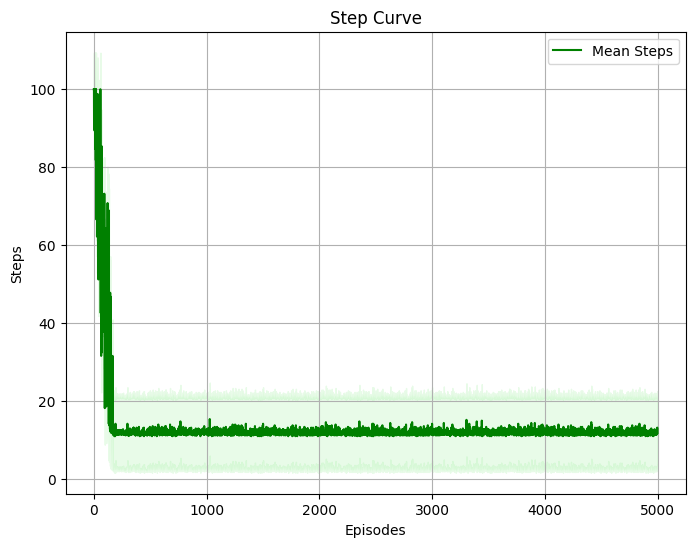

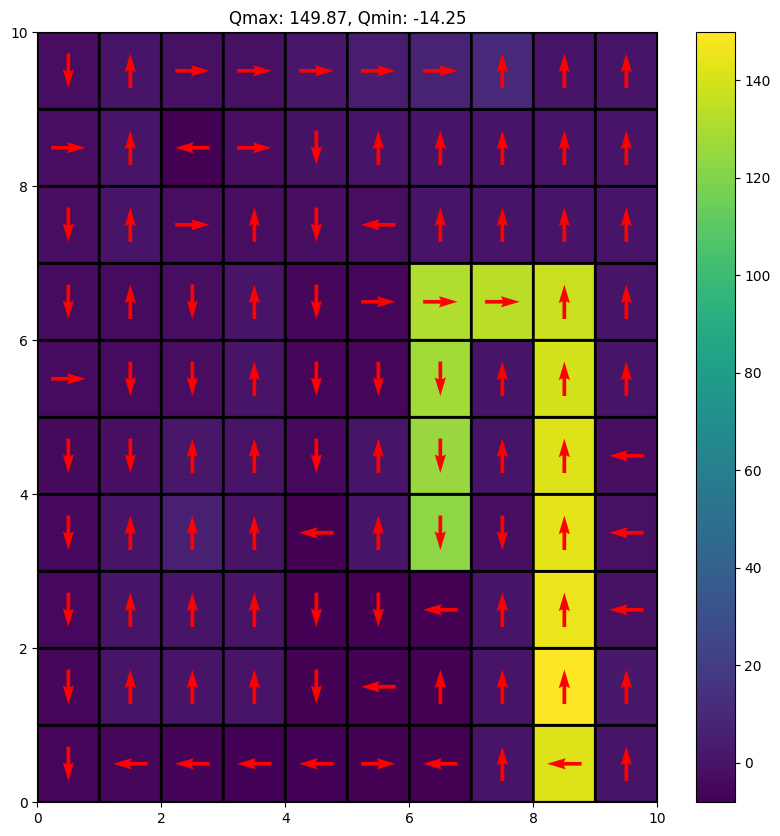

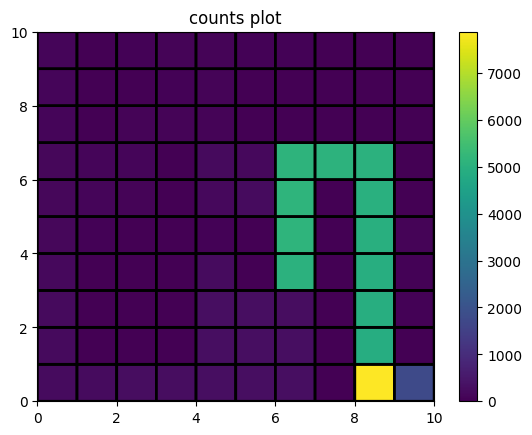

In [44]:
experiments=[[0.1,0.14,0.99,False,1.0,'sarsa',[0,4]],
             [0.15,0.14,0.99,False,0.7,'sarsa',[0,4]],
             [0.1,0.14,0.99,True,1.0,'sarsa',[0,4]],
             [0.1,0.14,0.99,False,1.0,'qlearning',[0,4]],
             [0.1,0.14,0.99,False,0.7,'qlearning',[0,4]],
             [0.1,0.1,0.99,True,1.0,'qlearning',[0,4]],
             [0.1,0.12,0.99,False,1.0,'sarsa',[3,6]],
             [0.2,0.1,0.99,False,0.7,'sarsa',[3,6]],
             [0.15,0.1,0.93,True,1.0,'sarsa',[3,6]],
             [0.2,0.1,0.99,False,1.0,'qlearning',[3,6]],
             [0.2,0.1,0.99,False,0.7,'qlearning',[3,6]],
             [0.1,0.12,0.99,True,1.0,'qlearning',[3,6]],]
for tau,alpha,gamma,wind,p,learning,start in experiments:
  print("tau = ",tau,"alpha = ",alpha,"gamma = ",gamma,"wind = ",wind,"p = ",p,"learning = ",learning,"start = ",start)
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
  restart_states = np.array([[3,7],[8,2]])
  start_state = np.array([start])
  goal_states = np.array([[0,9],[2,2],[8,7]])

  gw = GridWorld(num_rows=num_rows,
                num_cols=num_cols,
                start_state=start_state,
                goal_states=goal_states, wind = wind)
  gw.add_obstructions(obstructed_states=obstructions,
                      bad_states=bad_states,
                      restart_states=restart_states)
  gw.add_rewards(step_reward=-1,
                goal_reward=10,
                bad_state_reward=-6,
                restart_state_reward=-100)
  gw.add_transition_probability(p_good_transition=p,
                                bias=0.5)
  env = gw.create_gridworld()
  reward_avgs, reward_stds, steps_avgs, steps_stds, Q_values_mean, state_visit_avgs = plot_s(tau, alpha, gamma, env, wind, p, learning)
